In [1]:
import numpy as np
import pandas as pd

#Visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#SK Learn
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, f_regression

#Stats
from scipy.stats import pearsonr, spearmanr, kruskal, levene, ttest_ind
from statsmodels.stats.outliers_influence import variance_inflation_factor
from math import sqrt

import warnings
warnings.filterwarnings("ignore")

#My imports
import wrangle as w
import env
import model as m
import explore as e

In [2]:
df = w.get_zillow_data()

In [3]:
df.head(2)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,transactiondate,parcelid
0,4.0,3.5,3100.0,6059.0,33634931.0,-117869207.0,4506.0,1998.0,1023282.0,2017-01-01,14297519
1,2.0,1.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,1967.0,464000.0,2017-01-01,17052889


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52442 entries, 0 to 52441
Data columns (total 11 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   bedroomcnt                    52442 non-null  float64
 1   bathroomcnt                   52442 non-null  float64
 2   calculatedfinishedsquarefeet  52360 non-null  float64
 3   fips                          52442 non-null  float64
 4   latitude                      52442 non-null  float64
 5   longitude                     52442 non-null  float64
 6   lotsizesquarefeet             52073 non-null  float64
 7   yearbuilt                     52326 non-null  float64
 8   taxvaluedollarcnt             52441 non-null  float64
 9   transactiondate               52442 non-null  object 
 10  parcelid                      52442 non-null  int64  
dtypes: float64(9), int64(1), object(1)
memory usage: 4.4+ MB


In [5]:
#Clean the data, removing nulls, duplicates, and outliers, recast certain feature types, returns df
df = w.clean_zillow(df)

In [6]:
df.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
0,4,3.5,3100.0,6059,33634931.0,-117869207.0,4506,1998,1023282,2017-01-01,14297519,Orange,19
1,2,1.0,1465.0,6111,34449266.0,-119281531.0,12647,1967,464000,2017-01-01,17052889,Ventura,50


In [7]:
#Splitting our data
train, validate, test = w.train_validate_test_split(df)
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
22349,4,2.5,1922.0,6111,34291222.0,-119214999.0,7884,1967,554066,2017-05-05,17071716,Ventura,50
1037,3,2.0,1660.0,6037,34113036.0,-117867106.0,7656,1962,512588,2017-01-09,13036208,Los Angeles,55


In [8]:
print(f' Train length is {len(train)} rows')
print(f' Validate length is {len(validate)} rows')
print(f' Test length is {len(test)} rows')

 Train length is 34937 rows
 Validate length is 7489 rows
 Test length is 7488 rows


# Exploration

In [13]:
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
22349,4,2.5,1922.0,6111,34291222.0,-119214999.0,7884,1967,554066,2017-05-05,17071716,Ventura,50
1037,3,2.0,1660.0,6037,34113036.0,-117867106.0,7656,1962,512588,2017-01-09,13036208,Los Angeles,55


In [14]:
#Looking at target variable

In [20]:
round(train.tax_value.describe(),2)

count      34937.00
mean      430893.29
std       331310.63
min         1000.00
25%       186636.00
50%       357258.00
75%       576492.00
max      1827450.00
Name: tax_value, dtype: float64

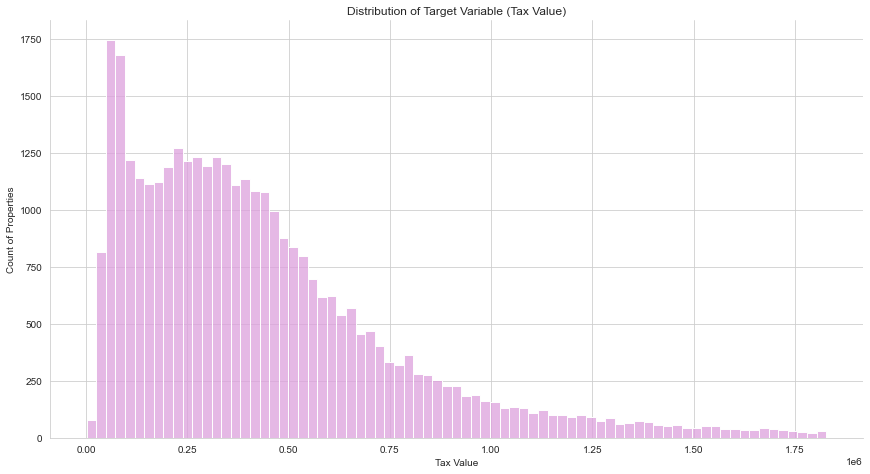

In [28]:
#Set Style
sns.set_style("whitegrid")
#Make the Plot
target = sns.displot(train['tax_value'],color='plum', height=6.5, aspect=15/8)
target.set_axis_labels("Tax Value", "Count of Properties")
target.set(title='Distribution of Target Variable (Tax Value)')
plt.show()
print()

<Figure size 864x576 with 0 Axes>

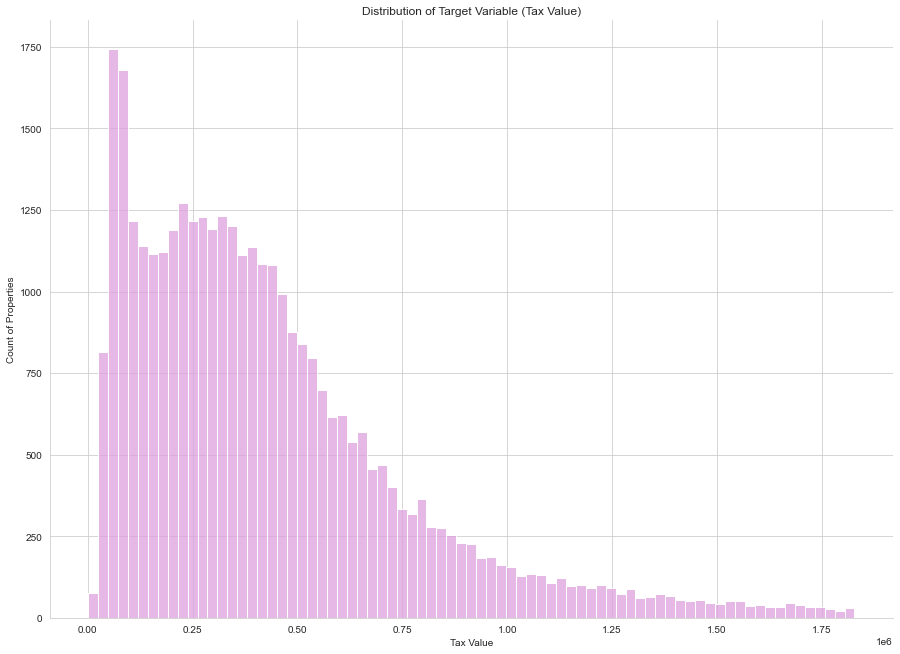

In [17]:
target_viz(train)

In [12]:
#Breaking down continuous vs categorical variables
cat_vars = ['bedrooms', 'county']
cont_vars = ['bathrooms', 'square_feet', 'lot_size', 'tax_value', 'home_age']

In [13]:
def plot_categorical_and_continuous_vars(df, cat_vars, cont_vars):
    for col in cat_vars:
        for col2 in cont_vars:
            fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,6))
            fig.suptitle(f'{col} vs. {col2}')
            sns.boxplot(data=df, x=col, y=col2, ax=ax1)
            sns.violinplot(data=df, x=col, y=col2, ax=ax2)
            sns.barplot(data=df, x=col, y=col2, ax=ax3)
            plt.show()

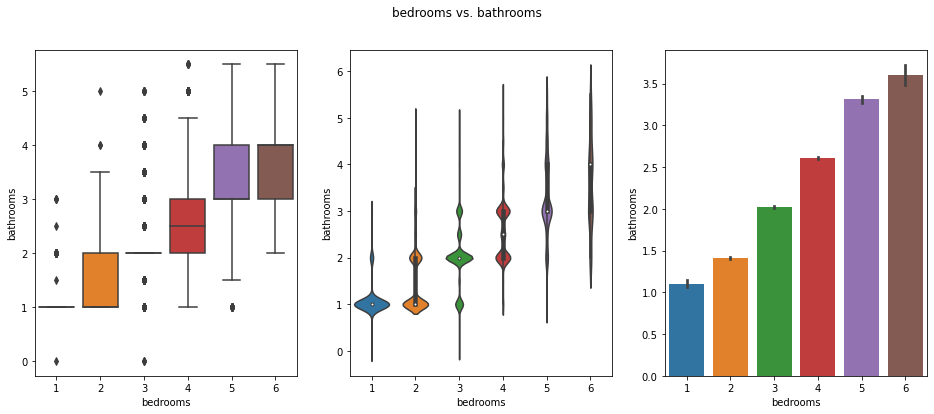

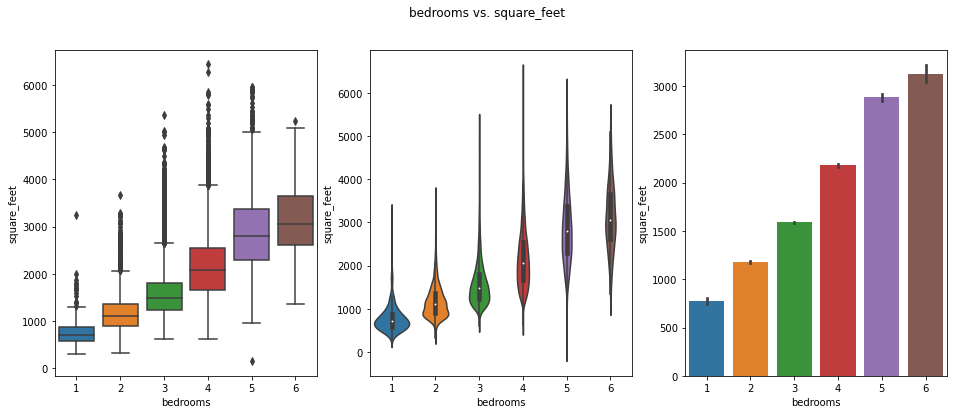

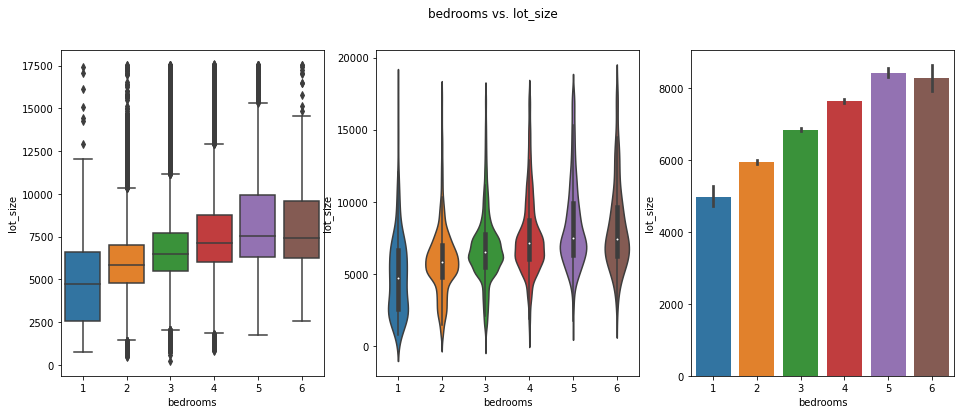

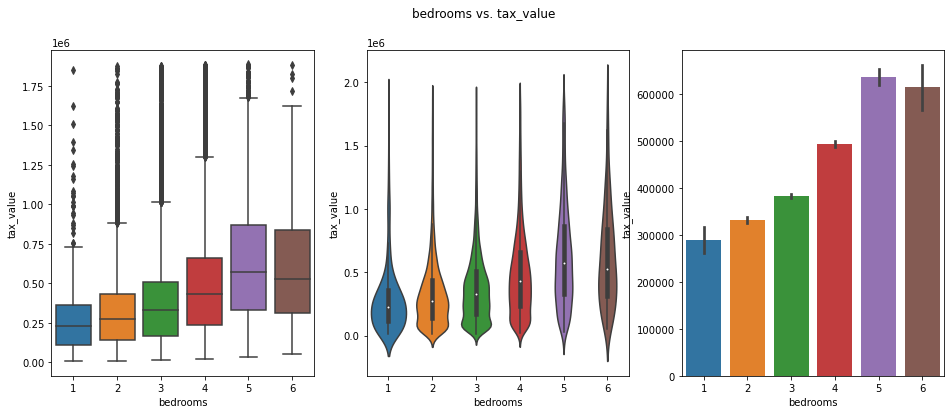

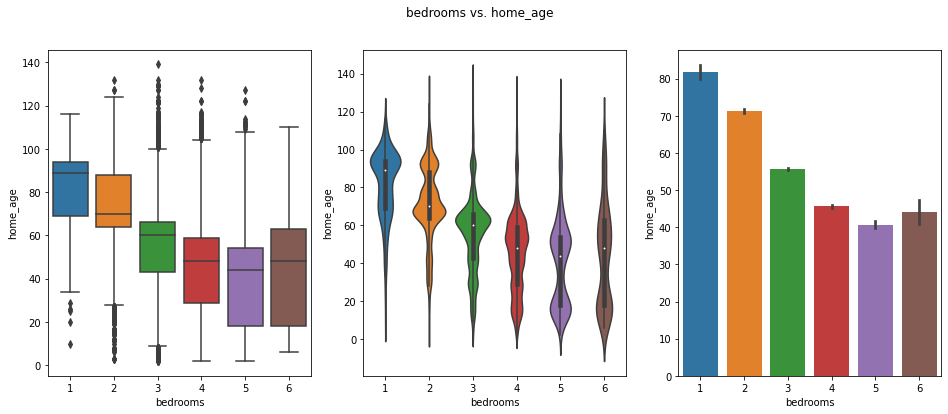

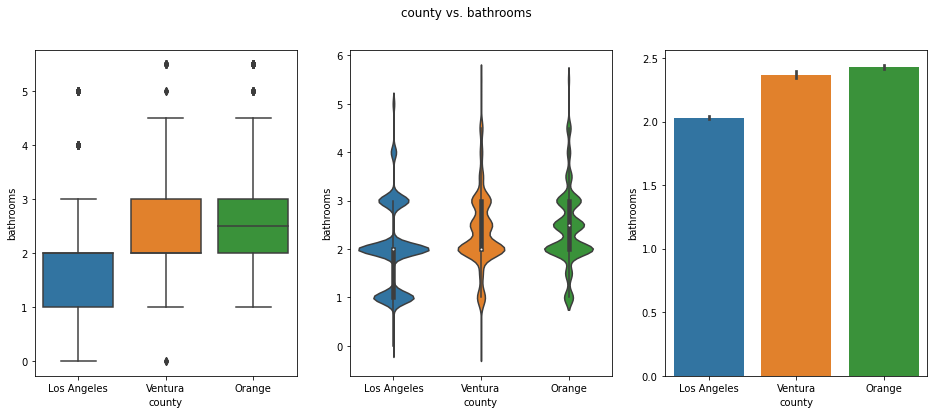

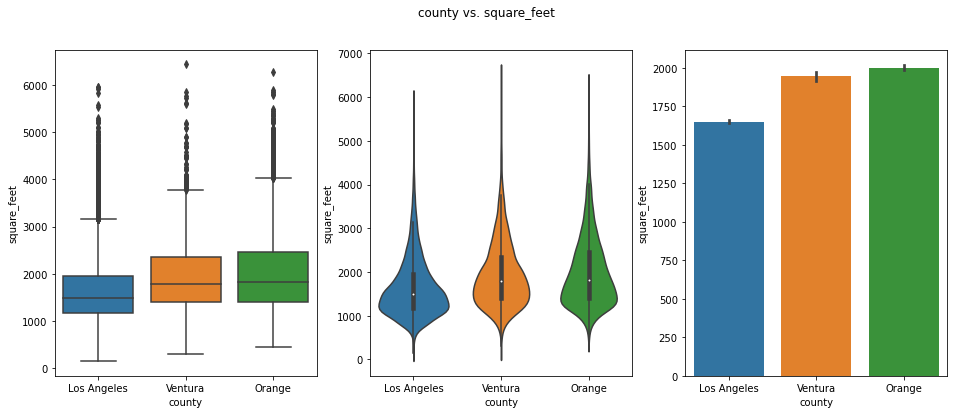

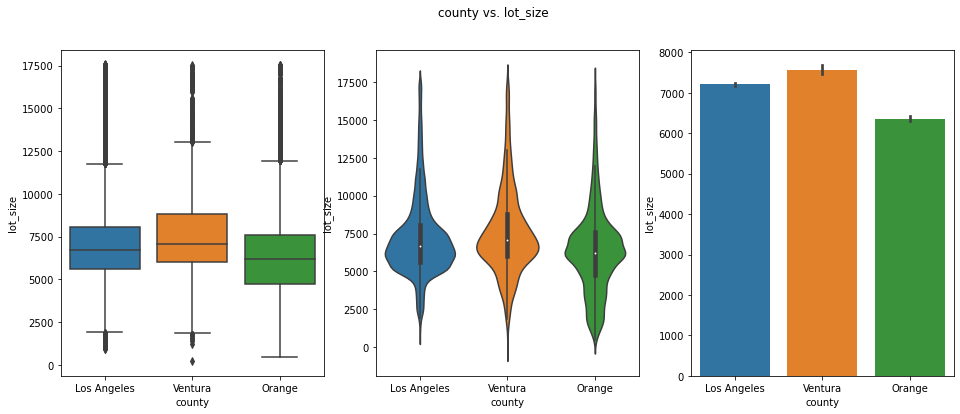

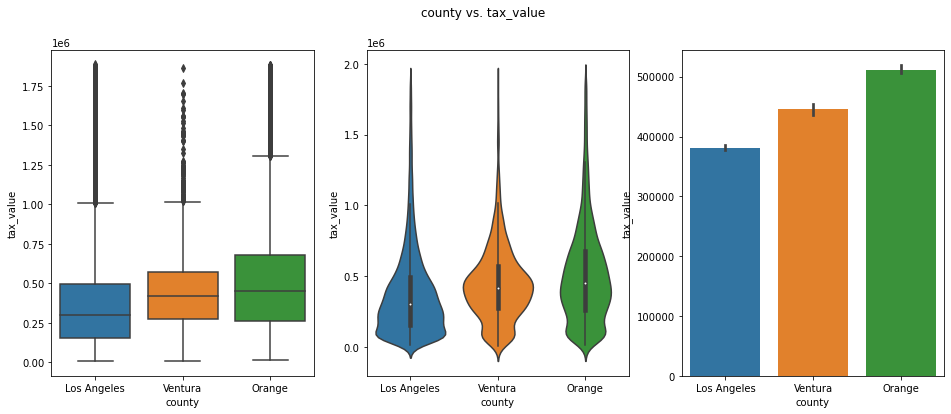

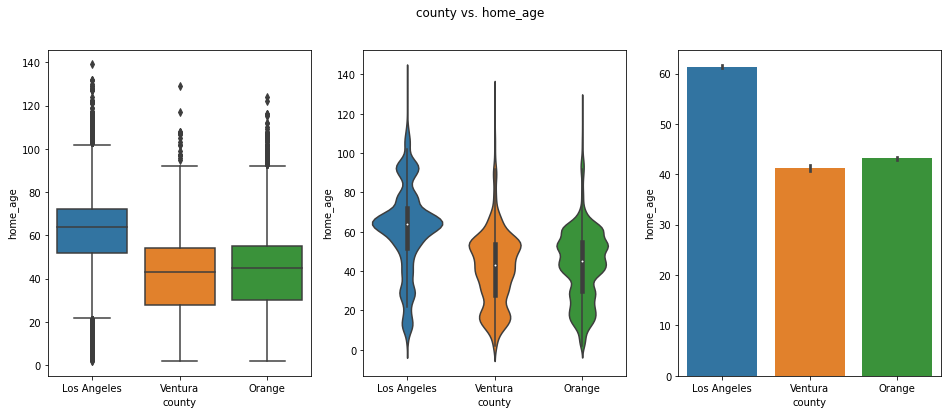

In [14]:
plot_categorical_and_continuous_vars(train, cat_vars, cont_vars)

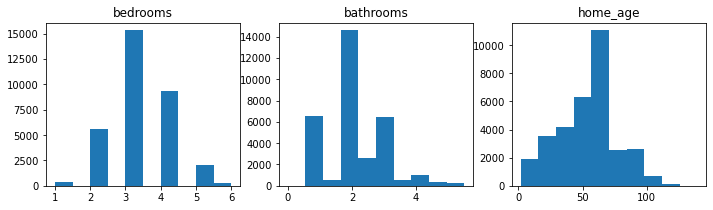

In [16]:
plt.figure(figsize=(16, 3))

# List of columns
cols = ['bedrooms', 'bathrooms', 'home_age', 'square_feet', '']
for i, col in enumerate(cols):
    # i starts at 0, but plot nos should start at 1
    subplot_num = i+1
    # Create subplot.
    plt.subplot(1,4,subplot_num)
    # Title with column name.
    plt.title(col)
    # Display histogram for column.
    train[col].hist(bins=10)
    # Hide gridlines.
    plt.grid(False)

bedrooms
3    15304
4     9359
2     5555
5     2065
1      357
6      263
Name: bedrooms, dtype: int64
3    46.512476
4    28.444215
2    16.882959
5     6.276023
1     1.085007
6     0.799319
Name: bedrooms, dtype: float64


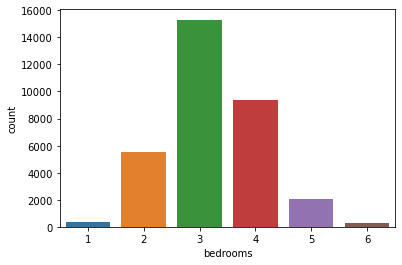

county
Los Angeles    21057
Orange          9155
Ventura         2691
Name: county, dtype: int64
Los Angeles    63.997204
Orange         27.824211
Ventura         8.178586
Name: county, dtype: float64


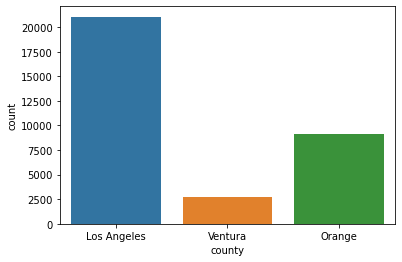

In [17]:
for col in cat_vars:
    print(col)
    print(train[col].value_counts())
    print(train[col].value_counts(normalize=True)*100)
    sns.countplot(x=col, data=train)
    plt.show()

### Bedrooms

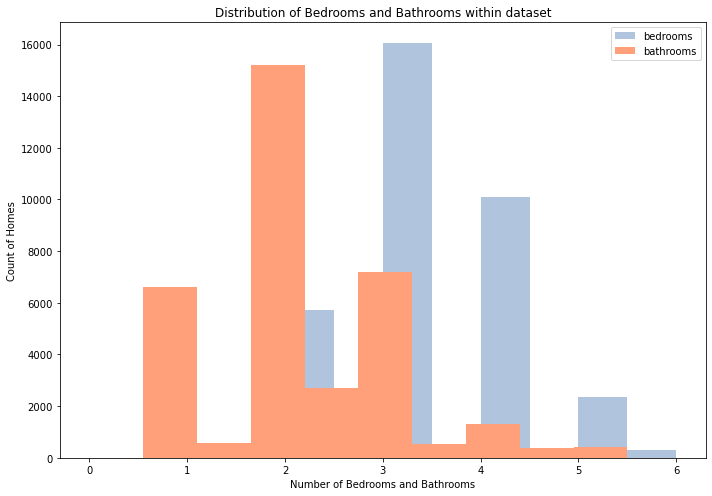

In [31]:
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7), tight_layout = True)
ax.hist(train.bedrooms, color='lightsteelblue', label='bedrooms')
ax.hist(train.bathrooms, color='lightsalmon', label='bathrooms')
plt.xlabel("Number of Bedrooms and Bathrooms")
plt.ylabel("Count of Homes")
plt.title('Distribution of Bedrooms and Bathrooms within dataset')
plt.legend()

# Show plot
plt.show()

In [34]:
#Make function for this plot
def get_hist_bedbath(train):
    '''This function takes in train and returns two histograms overlayed showing the distribution
    of bedrooms and bathrooms in the dataset'''
    # Creating histogram
    fig, ax = plt.subplots(figsize =(10, 7), tight_layout = True)
    ax.hist(train.bedrooms, color='lightsteelblue', label='bedrooms')
    ax.hist(train.bathrooms, color='lightsalmon', label='bathrooms')
    plt.xlabel("Number of Bedrooms and Bathrooms")
    plt.ylabel("Count of Homes")
    plt.title('Distribution of Bedrooms and Bathrooms within dataset')
    plt.legend()
    #Show plot
    plt.show()

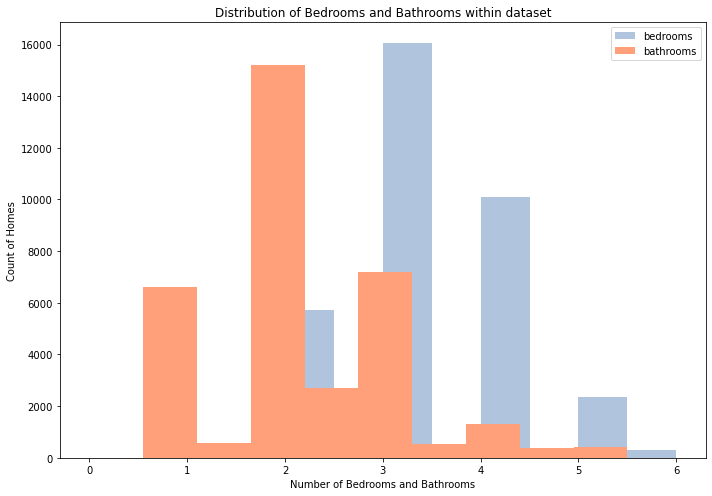

In [35]:
e.get_hist_bedbath(train)

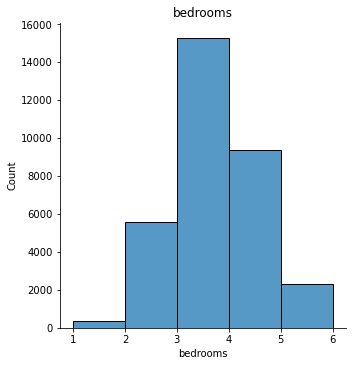

In [19]:
#Displot
sns.displot(x='bedrooms', data=train, bins=5)
plt.title('bedrooms')
plt.show()

### Continuous Variable Exploration

Mean bathrooms is: 2.168708020545239


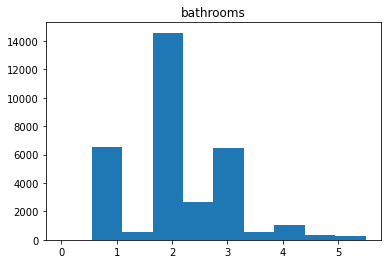

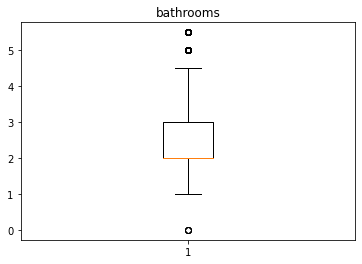

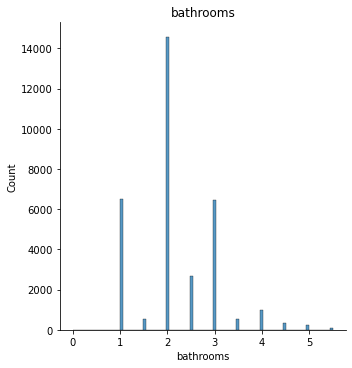

Mean square_feet is: 1771.0158040300278


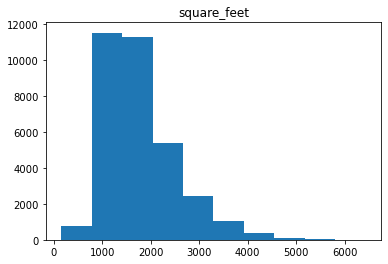

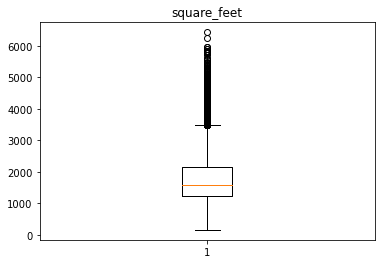

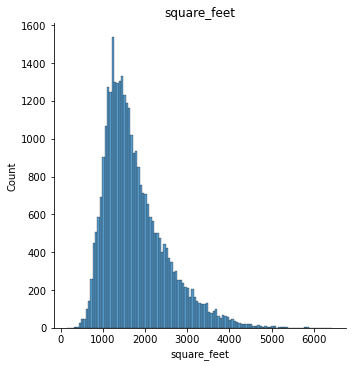

Mean lot_size is: 7001.801993739173


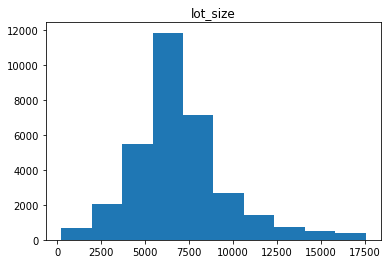

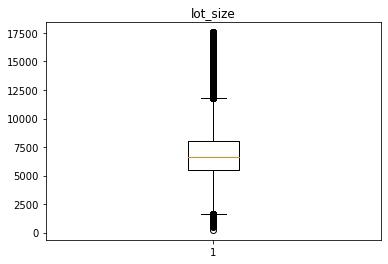

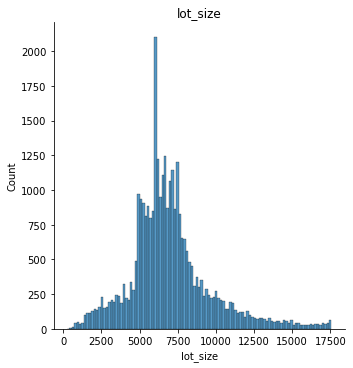

Mean tax_value is: 422949.6729173632


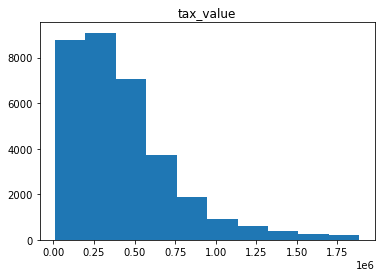

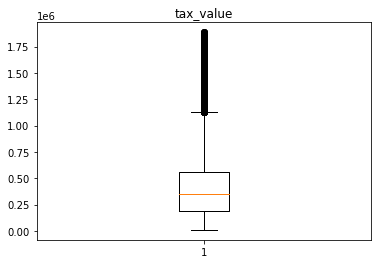

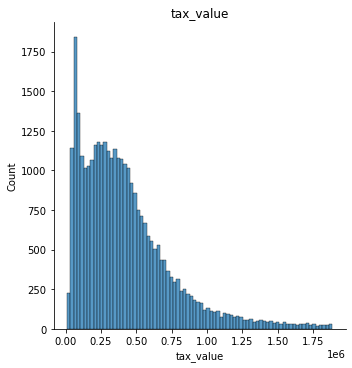

Mean home_age is: 54.67817524237911


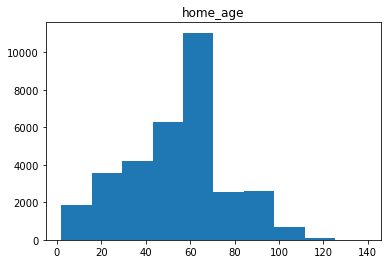

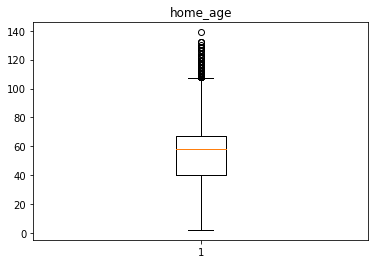

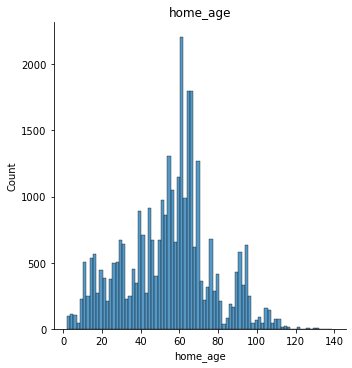

In [20]:
#Visualize other numeric data
# Plot numeric columns
for col in cont_vars:
    print(f'Mean {col} is: {train[col].mean()}')
    plt.hist(train[col])
    plt.title(col)
    plt.show()
    plt.boxplot(train[col])
    plt.title(col)
    plt.show()
    sns.displot(train[col])
    plt.title(col)
    plt.show()

In [21]:
#Descriptive statistics
print(f'Mean bedrooms = {train.bedrooms.mean()}')
print(f'Median Bedrooms = {train.bedrooms.median()}')
print(f'Mode Bedrooms = {train.bedrooms.mode()}')
print(f'Max Bedrooms = {train.bedrooms.max()}')
print(f'Min Bedrooms = {train.bedrooms.min()}')

Mean bedrooms = 3.2434124547913563
Median Bedrooms = 3.0
Mode Bedrooms = 0    3
Name: bedrooms, dtype: int64
Max Bedrooms = 6
Min Bedrooms = 1


In [22]:
#Bathrooms in train data set
train.bathrooms.value_counts()

2.0    14570
1.0     6527
3.0     6437
2.5     2653
4.0     1008
1.5      542
3.5      515
4.5      345
5.0      229
5.5       73
0.0        4
Name: bathrooms, dtype: int64

In [23]:
#Descriptive statistics of bathrooms
print(f'Mean Bathrooms = {train.bathrooms.mean()}')
print(f'Median Bathrooms = {train.bathrooms.median()}')
print(f'Mode Bathrooms = {train.bathrooms.mode()}')
print(f'Max Bathrooms = {train.bathrooms.max()}')
print(f'Min Bathrooms = {train.bathrooms.min()}')

Mean Bathrooms = 2.168708020545239
Median Bathrooms = 2.0
Mode Bathrooms = 0    2.0
Name: bathrooms, dtype: float64
Max Bathrooms = 5.5
Min Bathrooms = 0.0


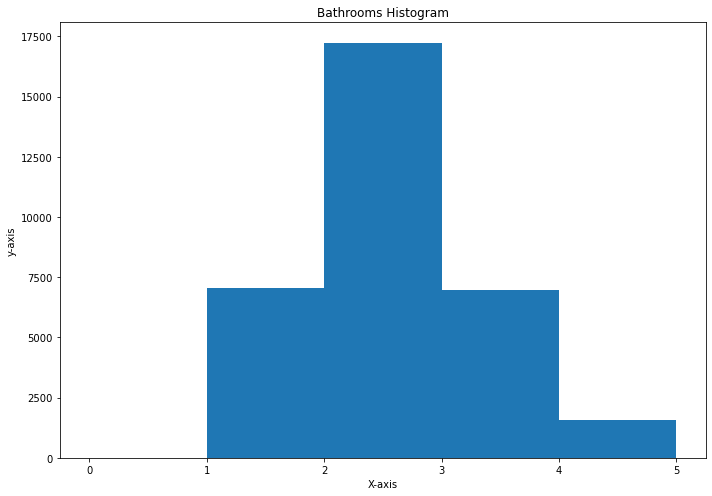

In [24]:
# Creating histogram
fig, ax = plt.subplots(figsize =(10, 7), tight_layout = True)
ax.hist(train.bathrooms, bins = [0, 1,2,3,4,5])
plt.xlabel("X-axis")
plt.ylabel("y-axis")
plt.title('Bathrooms Histogram')
 
# Show plot
plt.show()

In [54]:
train.mean()

bedrooms       3.264218e+00
bathrooms      2.206529e+00
square_feet    1.815371e+03
fips           6.049129e+03
latitude       3.402661e+07
longitude     -1.181918e+08
lot_size       1.068616e+04
year_built     1.962896e+03
tax_value      4.308933e+05
parcel_id      1.295564e+07
home_age       5.410407e+01
dtype: float64

In [55]:
three_bedroom = train[train.bedrooms == 3]
two_bathrooms = train[train.bedrooms == 2]

In [61]:
train.tax_value.median()

357258.0

In [62]:
three_bedroom.tax_value.median()

331664.0

In [63]:
two_bathrooms.tax_value.median()

271952.0

In [67]:
#Using median bathrooms and bedrooms to see if under median bedroom is more valuable than under median bathroom

In [84]:
def get_ttest_bedbath(train):
    # Create the samples
    bathrooms_above = train[(train.bathrooms > train.bathrooms.median())&(train.bedrooms < train.bedrooms.median())].tax_value
    bathrooms_below = train[(train.bathrooms < train.bathrooms.median())&(train.bedrooms > train.bedrooms.median())].tax_value
    
    #set alpha
    alpha = 0.05

    # Check for equal variances
    s, pval = levene(bathrooms_above, bathrooms_below)

    # Run the two-sample, one-tail T-test.
    # Use the results from checking for equal variances to set equal_var
    t, p = ttest_ind(bathrooms_above, bathrooms_below, equal_var=(pval >= alpha))

    # Evaluate results:
    return print(f'Test statistic: {t.round(2)}, P-Value: {p}')

In [85]:
get_ttest_bedbath(train)

Test statistic: 9.26, P-Value: 3.9030547897685863e-19


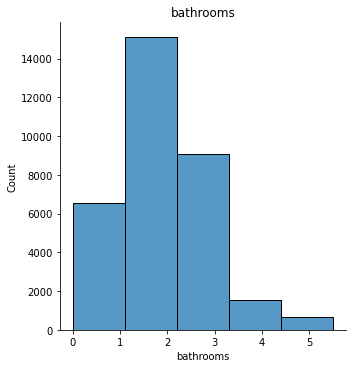

In [25]:
#Displot
sns.displot(x='bathrooms', data=train, bins=5)
plt.title('bathrooms')
plt.show()

In [ ]:
sns.pairplot(train)

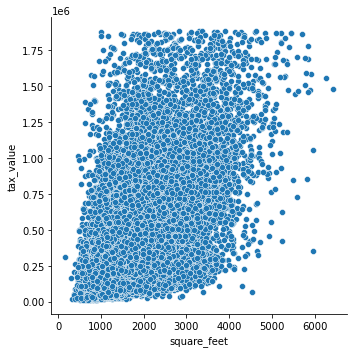

In [26]:
#Square Feet versus tax Value
sns.relplot(train['square_feet'], train['tax_value'], data=train)

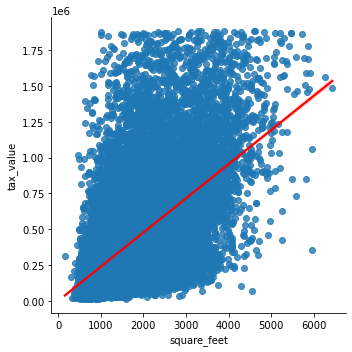

In [27]:
#Square Feet versus tax Value
sns.lmplot(x='square_feet', y='tax_value', data=train, scatter=True, line_kws={'color': 'red'})

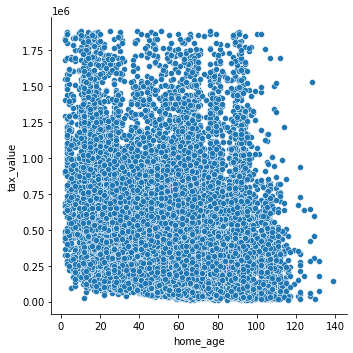

In [28]:
#bathrooms versus tax Value
sns.relplot(train['home_age'], train['tax_value'], data=train)

In [40]:
two_bedroom = train[train.bedrooms == 2]

In [41]:
one_bath = train[train.bathrooms == 1]

In [42]:
two_bedroom.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
25795,2,1.0,783.0,6037,34178740.0,-118511199.0,5608,1949,132983,2017-05-22,10850649,Los Angeles,68
45300,2,1.0,1364.0,6037,33781587.0,-118193383.0,4003,1910,158325,2017-08-16,12552916,Los Angeles,107


## County

In [10]:
LA = train[train.county == 'Los Angeles']
Orange = train[train.county == 'Orange']
Ventura = train[train.county == 'Ventura']

In [11]:
print(f'LA Mean Tax Value is: {round(LA.tax_value.mean())}')
print(f'Orange Mean Tax Value is: {round(Orange.tax_value.mean())}')
print(f'Ventura Mean Tax Value is: {round(Ventura.tax_value.mean())}')

LA Mean Tax Value is: 381318
Orange Mean Tax Value is: 511998
Ventura Mean Tax Value is: 445766


In [12]:
print(f'Count of properties in LA is: {len(LA.value_counts())}')
print(f'Count of properties in Orange is: {len(Orange.value_counts())}')
print(f'Count of properties in Ventura is: {len(Ventura.value_counts())}')

Count of properties in LA is: 21057
Count of properties in Orange is: 9155
Count of properties in Ventura is: 2691


#### The proportion of LA properties in train is 64 percent--while Ventura is only 8 percent. By including LA in the dataset, properties that are in LA county or not, this could be useful in predicting price. Properties outside of LA seem more valuable

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

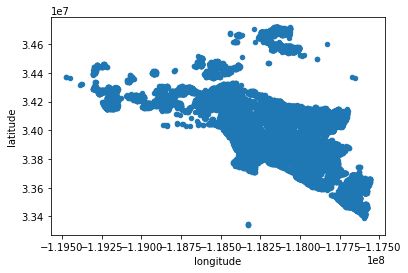

In [59]:
train.plot(x="longitude", y="latitude", kind="scatter", colormap="YlOrRd")

In [23]:
#Attempting to create a LA/Non-LA column
LA = train[train.county == 'Los Angeles']
not_LA = train[train.county != 'Los Angeles']

# Modeling Iteration 1

### Scaling Data

In [9]:
#Scaling data for modeling
train, validate, test = m.scale_data(
    train, validate, test, columns_to_scale=[
        'bedrooms', 'bathrooms', 'square_feet','lot_size','home_age'],return_scaler=False)

In [10]:
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
51187,0.6,0.363636,0.231577,6037,34117365.0,-117839192.0,0.394667,1958,137233,2017-09-12,13035327,Los Angeles,0.416058
3300,0.4,0.454545,0.390737,6111,34292708.0,-118681581.0,0.228501,2000,701000,2017-01-24,17240834,Ventura,0.109489


### Creating dummy variables for county

In [11]:
train = pd.get_dummies(train, columns=['county'], drop_first=False)
validate = pd.get_dummies(validate, columns=['county'], drop_first=False)
test = pd.get_dummies(test, columns=['county'], drop_first=False)

--------------------------------

### Modeling Iteration 1

In [20]:
#get clean data
train,validate,test = m.get_clean_data()
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
22349,4,2.5,1922.0,6111,34291222.0,-119214999.0,7884,1967,554066,2017-05-05,17071716,Ventura,50
1037,3,2.0,1660.0,6037,34113036.0,-117867106.0,7656,1962,512588,2017-01-09,13036208,Los Angeles,55


In [9]:
#Prep data for modeling iteration 1
X_train, X_validate, X_test, y_train, y_validate, y_test = m.model1_prep(train, validate, test)

In [10]:
X_train.head(2)

,bedrooms,bathrooms,square_feet
0,0.778779,0.680180,0.648649
1,0.404404,0.424424,0.520521


### MVP Model Calculation Using OLS (Bedrooms, Bathrooms, Square Feet vs Tax Value)-Model 1

In [11]:
#Create Baseline using mean
baseline = train.tax_value.mean()
baseline

430893.2876034004

In [12]:
y_train.head(2)

,tax_value
0,554066
1,512588


In [18]:
m1_eval = y_train.copy()
m1_eval = m1_eval.rename(columns={'tax_value': 'actual'})

In [21]:
m1_eval['baseline_yhat'] = m1_eval['actual'].mean()
m1_eval.head(2)

,actual,baseline_yhat
0,137233,422949.672917
1,701000,422949.672917


In [22]:
m1_eval['residuals'] = m1_eval.baseline_yhat - m1_eval.actual
m1_eval.head(2)

,actual,baseline_yhat,residuals
0,137233,422949.672917,285716.672917
1,701000,422949.672917,-278050.327083


In [23]:
#Initialize LR
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.tax_value)

LinearRegression(normalize=True)

In [25]:
#Make Predictions
m1_eval['ols_yhat'] = lm.predict(X_train)
m1_eval.head()

,actual,baseline_yhat,residuals,ols_yhat
0,137233,422949.672917,285716.672917,322399.001913
1,701000,422949.672917,-278050.327083,660560.056612
2,182017,422949.672917,240932.672917,670536.630982
3,316426,422949.672917,106523.672917,666869.445633
4,132983,422949.672917,289966.672917,210197.003999


In [26]:
#Calculate RMSE
from math import sqrt

ols_RMSE = sqrt(mean_squared_error(m1_eval.actual, m1_eval.ols_yhat))
ols_RMSE

271427.3521798709

In [27]:
#Calculate baseline RMSE
baseline_RMSE = sqrt(mean_squared_error(m1_eval.actual, m1_eval.baseline_yhat))
baseline_RMSE

327191.23778844386

In [31]:
# sklearn.metrics.explained_variance_score

evs = explained_variance_score(m1_eval.actual, m1_eval.ols_yhat)
print('Explained Variance = ', round(evs,3))

Explained Variance =  0.312


#### Difference in RMSE is 55764. R2 score is 0.31, so model isnt that great at predicting home value

### Examining RFE to select features to move to modeling iteration 2

### Trying RFE first with linear regression (either normalize = True or not)

In [ ]:
# initialize the ML algorithm
lm = LinearRegression(normalize=True)

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lm, n_features_to_select=3)

# fit the data using RFE
rfe.fit(X_train, y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()
rfe_feature

#### Changing n features to select from 3-5 gives different results. 

### RFE with lasso lars

In [ ]:
# initialize the ML algorithm
lars = LassoLars(alpha=1.0)

# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(lars, n_features_to_select=3)

# fit the data using RFE
rfe.fit(X_train, y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()
rfe_feature

In [ ]:
lars

#### Lasso Lars seems to be more consistent, giving bedrooms, bathrooms, square feet, and then adding on as you increase n features to select

### RFE Tweedie Regressor

In [ ]:
# create the model object
glm = TweedieRegressor(power=0, alpha=1.0)
# create the rfe object, indicating the ML object (lm) and the number of features I want to end up with. 
rfe = RFE(glm, n_features_to_select=3)

# fit the data using RFE
rfe.fit(X_train, y_train)  

# get the mask of the columns selected
feature_mask = rfe.support_

# get list of the column names. 
rfe_feature = X_train.iloc[:,feature_mask].columns.tolist()
rfe_feature

#### Not sure if Tweedie will end up being a good fit for final model, but bathrooms, square feet, and county LA seem to be the most driving. Lot Size and bedrooms become important as you add to n features to select

### RFE Polynomial Regression : Cannot complete

In [ ]:
plt.figure(figsize=(8,6))
sns.heatmap(zillow_corr, cmap='Purples', annot=True, linewidth=0.5, mask= np.triu(zillow_corr))
plt.show()

In [ ]:
# Pass my correlation matrix to Seaborn's heatmap.

kwargs = {'alpha':.9,'linewidth':3, 'linestyle':'-', 
          'linecolor':'k','rasterized':False, 'edgecolor':'w', 
          'capstyle':'projecting',}

plt.figure(figsize=(8,6))
sns.heatmap(zillow_corr, cmap='Purples', annot=True, mask= np.triu(zillow_corr), **kwargs)
plt.show()

### Question 1: What does the average home in this data set represent?

In [18]:
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
22349,4,2.5,1922.0,6111,34291222.0,-119214999.0,7884,1967,554066,2017-05-05,17071716,Ventura,50
1037,3,2.0,1660.0,6037,34113036.0,-117867106.0,7656,1962,512588,2017-01-09,13036208,Los Angeles,55


In [20]:
average_home = train[['bedrooms','bathrooms','square_feet','lot_size','year_built','tax_value','home_age']].mean()

In [24]:
Features = round(train[['bedrooms','bathrooms','square_feet','lot_size','year_built']])

bedrooms            3.264218
bathrooms           2.206529
square_feet      1815.370925
lot_size        10686.156167
year_built       1962.895927
tax_value      430893.287603
home_age           54.104073
dtype: float64

In [37]:
#turning this into a dataframe
average_home = pd.DataFrame(average_zillow_home)

In [17]:
average_home.columns = ['Feature', 'Value']

NameError: name 'average_home' is not defined

#### The average home from the Zillow Dataset is in LA County and has the following features:

### Question 2: Does home value increase more as bedrooms increase, or as bathrooms increase?

### Question 3: Is the mean home value of properties in LA County greater than or less than mean home value in Orange and Ventura counties?

In [48]:
LA = train[train.county == 'Los Angeles']
Not_LA = train[(train.county == 'Orange') | (train.county == 'Ventura')]

In [49]:
Not_LA.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
22349,4,2.5,1922.0,6111,34291222.0,-119214999.0,7884,1967,554066,2017-05-05,17071716,Ventura,50
530,5,3.0,2129.0,6059,33602865.0,-117667433.0,7566,1965,598997,2017-01-05,14472838,Orange,52


In [50]:
LA.tax_value.mean()

391029.9299602298

In [51]:
Not_LA.tax_value.mean()

504193.6681563338

#### Homes in LA county are significantly less valuable than homes in Orange or Ventura counties. However, the variation of home values within LA couty are wide. LA county contains approximately 90 cities. Even with outliers removed, the range of median home values within LA county in this data set is nearly 1.8 million. This is reflective of the diversity within LA County, which contains one of the nation's most expensive Zip Codes: Beverly Hills 90210, which in 2021 reflected median home prices ranking No. 6 nationally at 4.1 million. While one of the poorest cities in LA county, Compton, had a median home value of $355,200

In [57]:
print(f'LA Homes minimum value:{LA.tax_value.min()}')
print(f'LA Homes maximum value:{LA.tax_value.max()}')
print(f'LA Homes median value:{LA.tax_value.median()}')

LA Homes minimum value:1000
LA Homes maximum value:1827450
LA Homes median value:308550.5


In [58]:
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
22349,4,2.5,1922.0,6111,34291222.0,-119214999.0,7884,1967,554066,2017-05-05,17071716,Ventura,50
1037,3,2.0,1660.0,6037,34113036.0,-117867106.0,7656,1962,512588,2017-01-09,13036208,Los Angeles,55


# Statistical testing

### Bedrooms vs. Tax Value

In [36]:
train.bedrooms.value_counts()

3    16053
4    10102
2     5719
5     2371
1      394
6      298
Name: bedrooms, dtype: int64

In [22]:
## Treating Bedrooms as discrete variable, we need a T-Test
one_bed = train[train.bedrooms == 1]
two_bed = train[train.bedrooms == 2]
three_bed = train[train.bedrooms == 3]
four_bed = train[train.bedrooms == 4]
five_bed = train[train.bedrooms == 5]
six_bed = train[train.bedrooms == 6]

In [39]:
def kruskal_bedrooms(train):
    ## Creating new variables to make each bedroom count distinct
    one_bed = train[train.bedrooms == 1]
    two_bed = train[train.bedrooms == 2]
    three_bed = train[train.bedrooms == 3]
    four_bed = train[train.bedrooms == 4]
    five_bed = train[train.bedrooms == 5]
    six_bed = train[train.bedrooms == 6]
    #Running the kruskal test
    result = kruskal(
        one_bed.tax_value, two_bed.tax_value, three_bed.tax_value, four_bed.tax_value, five_bed.tax_value, six_bed.tax_value)
    return result

In [40]:
kruskal_bedrooms(train)

KruskalResult(statistic=2437.4735759228015, pvalue=0.0)

#### Formulate Hypotheses:
- The null hypothesis (H0): The median is the same for all the data groups.
- The alternative hypothesis: (Ha): The median is not equal for all the data groups.

In [26]:
#Performing an Kruskal-Wallis test to compare tax value between bedrooms because our variables are not normal
result = kruskal(
one_bed.tax_value, two_bed.tax_value, three_bed.tax_value, four_bed.tax_value, five_bed.tax_value, six_bed.tax_value
)
print(result)

KruskalResult(statistic=2460.336578686531, pvalue=0.0)


#### Since the P value is less than 0.05, we can reject the null hypothesis and say that there is a significant relationship between number of bedrooms and tax value.

### Bathrooms vs. Tax Value

In [27]:
#Treating bathrooms as continuous, we will run a spearman's R for bathrooms
train.bathrooms.value_counts()

2.0    15213
3.0     7195
1.0     6629
2.5     2723
4.0     1286
1.5      593
3.5      578
4.5      372
5.0      326
5.5       58
0.0        9
Name: bathrooms, dtype: int64

#### Forming a hypothesis:
- H^0: There is no relationship between bathrooms and tax value
- H^a: There is a relationship between bathrooms and tax value

In [47]:
#Running Spearman's R because my features and target are not normal
corr, p = spearmanr(train.bathrooms, train.tax_value)
corr, p
print(f'Test statstic is:{corr.round(2)}, p-value is:{p}')

Test statstic is:0.44, p-value is:0.0


#### Since the P value is less than 0.05, we can reject the null hypothesis and say that there is a relationship between number of bathrooms and tax value. Wherein, as number bathrooms increases, there is an increase in tax value (Positive Correlation)

### Square Feet vs. Tax Value

In [31]:
#Will run Spearman's as these are two continuous variables
print(f'Mean of square feet in train is: {train.square_feet.mean()}')
print(f'Median of square feet in train is: {train.square_feet.median()}')

Mean of square feet in train is: 1814.0413355439941
Median of square feet in train is: 1625.5


#### Forming a hypothesis:
- H^0: There is no relationship between square feet and tax value
- H^a: There is a relationship between square feet and tax value

In [33]:
#Running Spearman's R because my features and target are not normal
corr, p = spearmanr(train.square_feet, train.tax_value)
corr, p

(0.48478659231690785, 0.0)

#### Since the P value is less than 0.05, we can reject the null hypothesis and say that there is a relationship between square feet and tax value. Wherein, as square feet increases, there is an increase in tax value (Positive Correlation)

### County vs. Tax Value

In [37]:
# Will run Kruskal-Wallis on this as variables are not normal, categorical vs. continuous
LA = train[train.county == 'Los Angeles']
Orange = train[train.county == 'Orange']
Ventura = train[train.county == 'Ventura']

#### Formulate Hypotheses:
- The null hypothesis (H0): The mean is the same for all counties tax value.
- The alternative hypothesis: (Ha): The mean is not the same for all counties tax value.

In [38]:
result = kruskal(LA.tax_value, Orange.tax_value, Ventura.tax_value)
print(result)

KruskalResult(statistic=1473.9367854984202, pvalue=0.0)


#### Since the P value is less than 0.05, we can reject the null hypothesis and say that there is a significant relationship between county and tax value.

### Looking at LA county or NOT LA county

In [52]:
result = kruskal(LA.tax_value, Not_LA.tax_value)
print(result)

KruskalResult(statistic=1436.0241360646417, pvalue=0.0)


In [27]:
def get_kruskal_county(train):
    '''This function takes in train data and performs a Kruskal-Wallis correlation
    test, comparing properties in LA County with those in Orange and Ventura'''
    #Separating LA County properties and non-LA County properties
    LA = train[train.county == 'Los Angeles']
    not_LA = train[train.county != 'Los Angeles']
    result = kruskal(LA.tax_value, not_LA.tax_value)
    return result

In [28]:
get_kruskal_county(train)

KruskalResult(statistic=1436.0241360646417, pvalue=0.0)

#### Since the P value is less than 0.05, we can reject the null hypothesis and say that there is a significant relationship between homes in LA county and homes NOT in LA county, with respect to tax value.

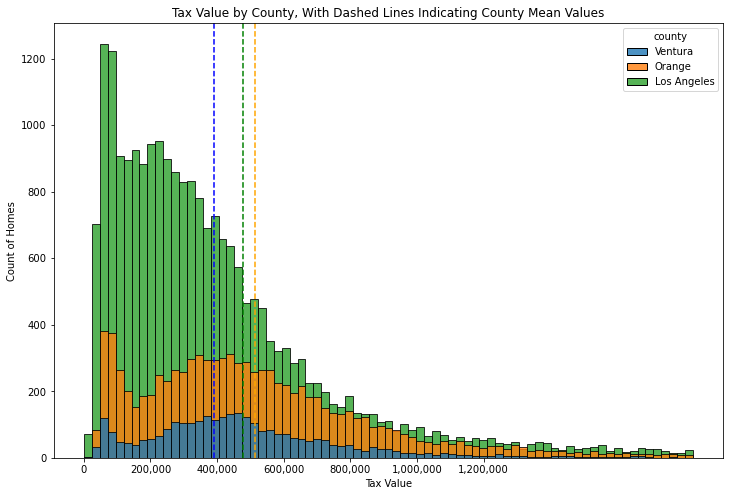

In [68]:


# Binning Home Value
train['brackets'] = pd.cut(train.tax_value, 10, labels=[1,2,3,4,5,6,7,8,9,10])
    
# Set Size
plt.figure(figsize=(12,8))
# plot it
sns.histplot(data=train, x='tax_value', alpha=.8, hue='county', hue_order=['Ventura', 'Orange', 'Los Angeles'])
# add lines marking the mean value at each location
plt.axvline(x=train[train.county == 'Los Angeles'].tax_value.mean(), color='blue', linestyle='--')
plt.axvline(x=train[train.county == 'Orange'].tax_value.mean(), color='orange', linestyle='--')
plt.axvline(x=train[train.county == 'Ventura'].tax_value.mean(), color='green', linestyle='--')
    
# axis tick labeling using
plt.xticks(ticks = [0,200000,400000,600000,800000,1000000, 1200000], labels=['0', '200,000', '400,000', '600,000', '800,000', '1,000,000', '1,200,000'])
    
# Make a title, label the axes
plt.title('Tax Value by County, With Dashed Lines Indicating County Mean Values')
plt.xlabel('Tax Value')
plt.ylabel('Count of Homes')
plt.show()
    
print()

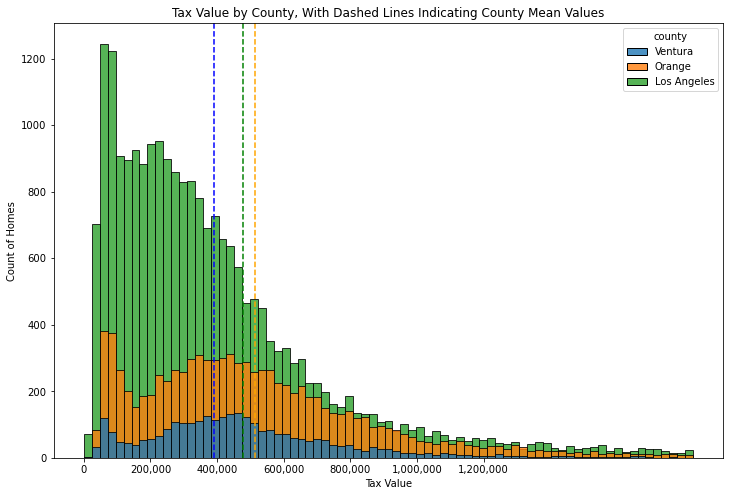

In [10]:
e.location_viz(train)

### Home age vs. Tax Value

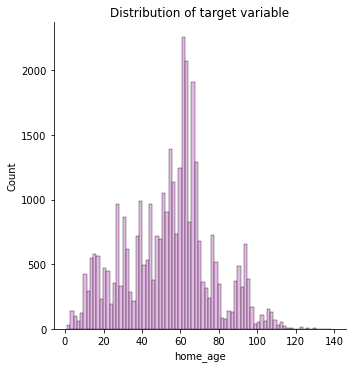

In [21]:
sns.displot(train['home_age'], color='plum')
plt.title('Distribution of target variable')
plt.show()

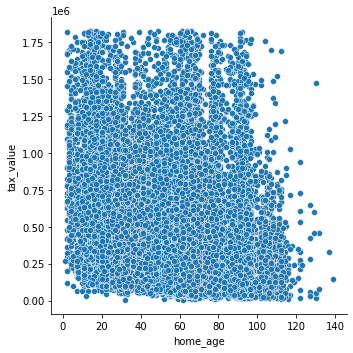

In [97]:
sns.relplot('home_age', 'tax_value', data=train, kind='scatter')

In [ ]:
# Binning Tax Value
train['brackets'] = pd.cut(train.tax_value, 10, labels=[1,2,3,4,5,6,7,8,9,10])
    
    # Set Size
    plt.figure(figsize=(12,8))
    # plot it
    sns.histplot(data=train, x='tax_value', alpha=.8, hue='county', hue_order=['Ventura', 'Orange', 'Los Angeles'])
    # add lines marking the mean value at each location
    plt.axvline(x=train[train.county == 'Los Angeles'].tax_value.mean(), color='blue', linestyle='--')
    plt.axvline(x=train[train.county == 'Orange'].tax_value.mean(), color='orange', linestyle='--')
    plt.axvline(x=train[train.county == 'Ventura'].tax_value.mean(), color='green', linestyle='--')
    
    # axis tick labeling using
    plt.xticks(ticks = [0,200000,400000,600000,800000,1000000, 1200000], labels=['0', '200,000', '400,000', '600,000', '800,000', '1,000,000', '1,200,000'])
    
    # Make a title, label the axes
    plt.title('Tax Value by County, With Dashed Lines Indicating County Mean Values')
    plt.xlabel('Tax Value')
    plt.ylabel('Count of Homes')
    plt.show()
    
    print()

In [4]:
#Looking at home age versus tax value

In [6]:
#Get clean data
train,validate,test = m.get_clean_data()
train.head(2)

#### Forming a hypothesis:
- H^0: There is no relationship between home age and tax value
- H^a: There is a relationship between home age and tax value

In [18]:
#Running Spearman's R because my features and target are not normal
corr, p = spearmanr(train.home_age, train.tax_value)
corr, p

(-0.26571503469118796, 0.0)

#### Since the P value is less than 0.05, we can reject the null hypothesis and say that there is a relationship between home age and tax value. Wherein, as home age increases, there is a decrease in tax value

### Testing Variance Inflation Factor

In [ ]:
#Need to make county a dummy variable so I can use it in this
#Make dummy variables from county and rename them to make it easier
#train = pd.get_dummies(train, columns=['county'], drop_first=False)
train = train.rename(columns = {'county_Los Angeles':'LA', 'county_Orange':'Orange','county_Ventura':'Ventura'})

In [ ]:
train.head()

In [ ]:
#Using all variables for this first
X = train[['square_feet','bathrooms','home_age', 'LA']]
# VIF dataframe
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
  
# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                          for i in range(len(X.columns))]
  
vif_data

## Modeling iteration 2 (Features: Bathrooms, Square Feet, Home Age, LA)

In [34]:
def get_clean_data():
    '''This function retrieves clean data to perform modeling'''
    #Retrieve Zillow data from CSV or Codeup mySQL database
    df = w.get_zillow_data()
    #Clean the data
    df = w.clean_zillow(df)
    #Split the data
    train, validate, test = w.train_validate_test_split(df)
    
    return train, validate, test

In [2]:
train, validate, test = m.get_clean_data()

In [3]:
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
51187,4,2.0,1607.0,6037,34117365.0,-117839192.0,7074,1958,137233,2017-09-12,13035327,Los Angeles,59
3300,3,2.5,2607.0,6111,34292708.0,-118681581.0,4195,2000,701000,2017-01-24,17240834,Ventura,17


In [8]:
def model2_prep(train,validate,test):
    '''
    This function prepares train, validate, test for model 2 by dropping columns not necessary
    or compatible with modeling algorithms, splitting data into target and feature (X and Y), and
    scaling data for modeling
    '''
    #Make Dummy Variables for county
    train = pd.get_dummies(train, columns=['county'], drop_first=False)
    validate = pd.get_dummies(validate, columns=['county'], drop_first=False)
    test = pd.get_dummies(test, columns=['county'], drop_first=False)
    
    #Change column names for dummy variables
    train = train.rename(columns={'county_Los Angeles': 'LA', 'county_Orange':'Orange','county_Ventura':'Ventura'})
    validate = validate.rename(columns={'county_Los Angeles': 'LA', 'county_Orange':'Orange','county_Ventura':'Ventura'})
    test = test.rename(columns={'county_Los Angeles': 'LA', 'county_Orange':'Orange','county_Ventura':'Ventura'})
    
    # drop columns not needed for model 2
    keep_cols = ['bathrooms',
                 'square_feet',
                 'home_age',
                 'LA',
                 'tax_value',
                 ]
    
    train = train[keep_cols]
    validate = validate[keep_cols]
    test = test[keep_cols]

    # Split data into predicting variables (X) and target variable (y) and reset the index for each dataframe
    X_train = train.drop(columns='tax_value').reset_index(drop=True)
    y_train = train[['tax_value']].reset_index(drop=True)

    X_validate = validate.drop(columns='tax_value').reset_index(drop=True)
    y_validate = validate[['tax_value']].reset_index(drop=True)

    X_test = test.drop(columns='tax_value').reset_index(drop=True)
    y_test = test[['tax_value']].reset_index(drop=True)
    
    # Scaling data for modeling
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train_scaled = scaler.transform(X_train)
    X_validate_scaled = scaler.transform(X_validate)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [4]:
X_train, X_validate, X_test, y_train, y_validate, y_test = m.model2_prep(train,validate,test)

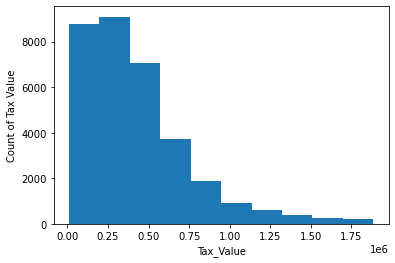

In [5]:
#Visualize Target Variable
plt.hist(y_train)
plt.xlabel("Tax_Value")
plt.ylabel("Count of Tax Value")
plt.show()

In [6]:
X_train.head(2)

,bathrooms,square_feet,home_age,LA
0,2.0,1607.0,59,1
1,2.5,2607.0,17,0


### Making predictions using my model 2: Polynomial Features 3rd degree

In [7]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. compute tax_value_pred_mean

tax_value_pred_mean = y_train['tax_value'].mean()
y_train['tax_value_pred_mean'] = tax_value_pred_mean
y_validate['tax_value_pred_mean'] = tax_value_pred_mean

# 4. RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_mean)**(1/2)

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  327191.24 
Validate/Out-of-Sample:  330921.44


In [ ]:
#Need to re-run this without scaled data
# plot to visualize actual vs predicted. 
plt.hist(y_train.tax_value, color='blue', alpha=.5, label="Actual Tax Value")
plt.hist(y_train.tax_value_pred_median, bins=1, color='red', alpha=.5, rwidth=100, label="Predicted Tax Value = mean")
plt.xlabel("Tax Value")
plt.ylabel("Count of Homes")
plt.legend()
plt.show()

In [8]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [9]:
# create the model object
pf3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
pf3.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_pf3'] = pf3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_pf3)**(1/2)

# predict validate
y_validate['tax_value_pred_pf3'] = pf3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_pf3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  263879.7238055108 
Validation/Out-of-Sample:  265939.26312497375


### Plotting Actual vs Predicted values for Polynomial Features (Model 2)

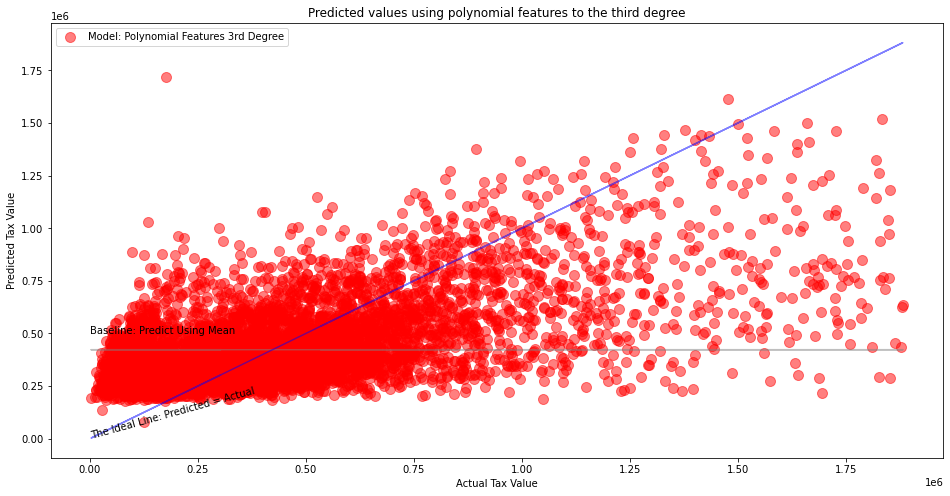

In [19]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.tax_value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (0, 500000))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5), rotation=15.5)

plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_pf3, 
            alpha=.5, color="red", s=100, label="Model: Polynomial Features 3rd Degree")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Predicted values using polynomial features to the third degree")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Plotting Errors in my predictions

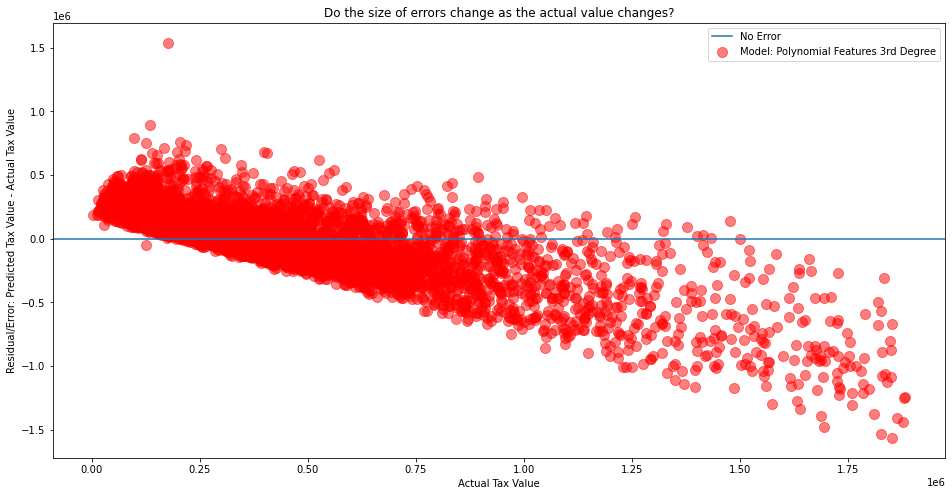

In [20]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.axhline(label="No Error")
plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_pf3-y_validate.tax_value, 
            alpha=.5, color="red", s=100, label="Model: Polynomial Features 3rd Degree")
#plt.scatter(y_validate.tax_value, y_validate.tax_value_pred_pf3-y_validate.tax_value, 
            #alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
#plt.scatter(y_validate.G3, y_validate.G3_pred_lm2-y_validate.G3, 
            #alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Residual/Error: Predicted Tax Value - Actual Tax Value")
plt.title("Do the size of errors change as the actual value changes?")
#plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
#plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

### Plot to visualize actual vs predicted

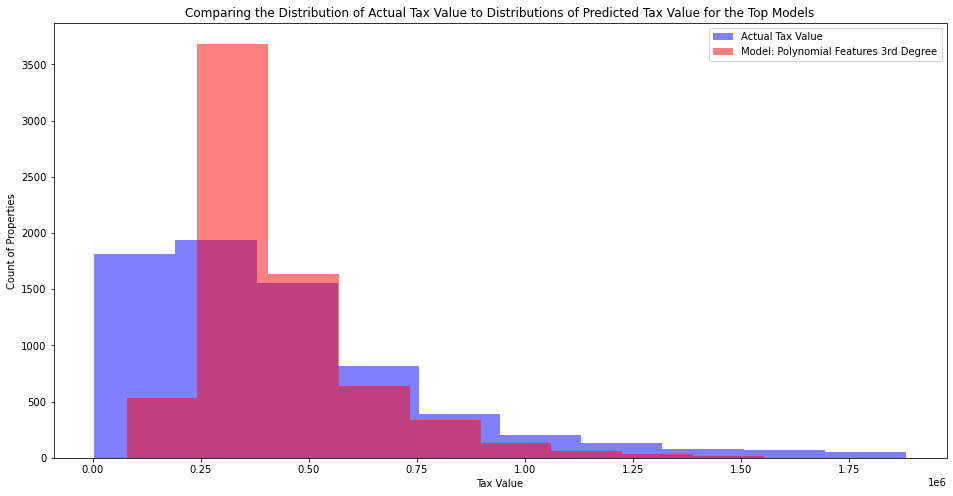

In [21]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Tax Value")
plt.hist(y_validate.tax_value_pred_pf3, color='red', alpha=.5, label="Model: Polynomial Features 3rd Degree")
plt.xlabel("Tax Value")
plt.ylabel("Count of Properties")
plt.title("Comparing the Distribution of Actual Tax Value to Distributions of Predicted Tax Value for the Top Models")
plt.legend()
plt.show()

#### Polynomial Features 3rd degree gave RMSE of 263,877 to in sample and 265,954 to out of sample data, for a difference of 2,077. 4th and 2nd degree were not as good

### Model Pause: Let's check these features on different model types


In [ ]:
#Linear Regression
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lm)**(1/2)

# predict validate
y_validate['tax_value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lm)**(1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

#### Linear Regression did not perform as well with RMSE scores of : Training/In-Sample:  273614, Validation/Out-of-Sample:  275409

In [ ]:
#Lasso-Lars
#create the model object
lars = LassoLars(alpha=1)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_lars)**(1/2)

# predict validate
y_validate['tax_value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_lars)**(1/2)

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

#### RMSE for Lasso Lars is similar to Linear Regression: Training/In-Sample:  273614, Validation/Out-of-Sample:  275420

In [ ]:
#Trying Tweedie Regressor
# create the model object
glm = TweedieRegressor(power=1, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
glm.fit(X_train, y_train.tax_value)

# predict train
y_train['tax_value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_glm)**(1/2)

# predict validate
y_validate['tax_value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_glm)**(1/2)

print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

#### RMSE for Tweedie (GLS) is not as good as Lasso-Lars with Training/In-Sample:  274707,  Validation/Out-of-Sample:  274456

## Modeling Iteration 3: Features (Bedrooms, Square Feet, Home Age, LA)

In [21]:
#Get clean data
train, validate, test = m.get_clean_data()

In [22]:
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
51187,4,2.0,1607.0,6037,34117365.0,-117839192.0,7074,1958,137233,2017-09-12,13035327,Los Angeles,59
3300,3,2.5,2607.0,6111,34292708.0,-118681581.0,4195,2000,701000,2017-01-24,17240834,Ventura,17


In [23]:
def model3_prep(train,validate,test):
    '''
    This function prepares train, validate, test for model 3 by dropping columns not necessary
    or compatible with modeling algorithms, splitting data into target and feature (X and Y), and
    scaling data for modeling
    '''
    #Scaling Data
    train, validate, test = m.scale_data(
        train, validate, test, columns_to_scale=['bedrooms', 'square_feet','home_age'], return_scaler=False)

    #Make Dummy Variables for county
    train = pd.get_dummies(train, columns=['county'], drop_first=False)
    validate = pd.get_dummies(validate, columns=['county'], drop_first=False)
    test = pd.get_dummies(test, columns=['county'], drop_first=False)
    
    #Change column names for dummy variables
    train = train.rename(columns={'county_Los Angeles': 'LA', 'county_Orange':'Orange','county_Ventura':'Ventura'})
    validate = validate.rename(columns={'county_Los Angeles': 'LA', 'county_Orange':'Orange','county_Ventura':'Ventura'})
    test = test.rename(columns={'county_Los Angeles': 'LA', 'county_Orange':'Orange','county_Ventura':'Ventura'})
    
    # drop columns not needed for model 2
    keep_cols = ['bedrooms',
                 'square_feet',
                 'home_age',
                 'LA',
                 'tax_value',
                 ]
    
    train = train[keep_cols]
    validate = validate[keep_cols]
    test = test[keep_cols]

    # Split data into predicting variables (X) and target variable (y) and reset the index for each dataframe
    X_train = train.drop(columns='tax_value').reset_index(drop=True)
    y_train = train[['tax_value']].reset_index(drop=True)

    X_validate = validate.drop(columns='tax_value').reset_index(drop=True)
    y_validate = validate[['tax_value']].reset_index(drop=True)

    X_test = test.drop(columns='tax_value').reset_index(drop=True)
    y_test = test[['tax_value']].reset_index(drop=True)
    
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [24]:
X_train, X_validate, X_test, y_train, y_validate, y_test = model3_prep(train,validate,test)

In [26]:
X_train.head(2)

,bedrooms,square_feet,home_age,LA
0,0.6,0.231577,0.416058,1
1,0.4,0.390737,0.109489,0


In [ ]:
# We need y_train and y_validate to be dataframes to append the new columns with predicted values. 
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)

# 1. compute tax_value_pred_mean

tax_value_pred_median = y_train['tax_value'].median()
y_train['tax_value_pred_median'] = tax_value_pred_median
y_validate['tax_value_pred_median'] = tax_value_pred_median

# 4. RMSE of tax_value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_median)**(1/2)
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_median)**(1/2)

print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

In [27]:
#Polynomial Features
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [28]:
# create the model object
pf3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
pf3.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_pf3'] = pf3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_pf3)**(1/2)

# predict validate
y_validate['tax_value_pred_pf3'] = pf3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_pf3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  263845.5364800431 
Validation/Out-of-Sample:  266369.72024936136


#### Model 3 (Bedrooms, Sq Feet, Home Age, LA) performed similarly on train, but with a bigger difference on validate: Training/In-Sample:  263846, Validation/Out-of-Sample:  266370

## Modeling Iteration 4: Features (Bedrooms, Bathrooms, Square Feet, Home Age, LA)

In [31]:
#Get clean data
train,validate,test = m.get_clean_data()

In [32]:
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
51187,4,2.0,1607.0,6037,34117365.0,-117839192.0,7074,1958,137233,2017-09-12,13035327,Los Angeles,59
3300,3,2.5,2607.0,6111,34292708.0,-118681581.0,4195,2000,701000,2017-01-24,17240834,Ventura,17


In [33]:
def model4_prep(train,validate,test):
    '''
    This function prepares train, validate, test for model 4 by dropping columns not necessary
    or compatible with modeling algorithms, splitting data into target and feature (X and Y), and
    scaling data for modeling
    '''
    #Scaling Data
    train, validate, test = m.scale_data(
        train, validate, test, columns_to_scale=['bedrooms','bathrooms','square_feet','home_age'], return_scaler=False)

    #Make Dummy Variables for county
    train = pd.get_dummies(train, columns=['county'], drop_first=False)
    validate = pd.get_dummies(validate, columns=['county'], drop_first=False)
    test = pd.get_dummies(test, columns=['county'], drop_first=False)
    
    #Change column names for dummy variables
    train = train.rename(columns={'county_Los Angeles': 'LA', 'county_Orange':'Orange','county_Ventura':'Ventura'})
    validate = validate.rename(columns={'county_Los Angeles': 'LA', 'county_Orange':'Orange','county_Ventura':'Ventura'})
    test = test.rename(columns={'county_Los Angeles': 'LA', 'county_Orange':'Orange','county_Ventura':'Ventura'})
    
    # drop columns not needed for model 2
    keep_cols = ['bedrooms',
                 'bathrooms',
                 'square_feet',
                 'home_age',
                 'LA',
                 'tax_value',
                 ]
    
    train = train[keep_cols]
    validate = validate[keep_cols]
    test = test[keep_cols]

    # Split data into predicting variables (X) and target variable (y) and reset the index for each dataframe
    X_train = train.drop(columns='tax_value').reset_index(drop=True)
    y_train = train[['tax_value']].reset_index(drop=True)

    X_validate = validate.drop(columns='tax_value').reset_index(drop=True)
    y_validate = validate[['tax_value']].reset_index(drop=True)

    X_test = test.drop(columns='tax_value').reset_index(drop=True)
    y_test = test[['tax_value']].reset_index(drop=True)
    
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [34]:
X_train, X_validate, X_test, y_train, y_validate, y_test = model4_prep(train,validate,test)

In [35]:
X_train.head(2)

,bedrooms,bathrooms,square_feet,home_age,LA
0,0.6,0.363636,0.231577,0.416058,1
1,0.4,0.454545,0.390737,0.109489,0


In [36]:
#Polynomial Features
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [37]:
# create the model object
pf3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
pf3.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_pf3'] = pf3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_pf3)**(1/2)

# predict validate
y_validate['tax_value_pred_pf3'] = pf3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_pf3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  261446.81598804137 
Validation/Out-of-Sample:  263557.7419617677


#### Model 4 (Using both bed and bath) had a lower RMSE 

### Calculating residuals and R2 for Model 4

In [41]:
y_train.head()

,tax_value,tax_value_pred_pf3
0,137233,319141.672917
1,701000,741063.445385
2,182017,750885.672917
3,316426,590245.672917
4,132983,226661.672917


In [42]:
m4_eval = y_train.copy()
m4_eval = m4_eval.rename(columns={'tax_value':'actual','tax_value_pred_pf3': 'yhat'})
m4_eval.head(2)

In [43]:
m4_eval.head(2)

,actual,yhat
0,137233,319141.672917
1,701000,741063.445385


In [44]:
m4_eval['baseline_yhat'] = m4_eval['actual'].mean()
m4_eval.head(2)

,actual,yhat,baseline_yhat
0,137233,319141.672917,422949.672917
1,701000,741063.445385,422949.672917


In [45]:
m4_eval['residuals'] = m4_eval.baseline_yhat - m4_eval.actual
m4_eval.head(2)

,actual,yhat,baseline_yhat,residuals
0,137233,319141.672917,422949.672917,285716.672917
1,701000,741063.445385,422949.672917,-278050.327083


In [48]:
# sklearn.metrics.explained_variance_score
#from sklearn.metrics import explained_variance_score
evs_model_4 = explained_variance_score(m4_eval.actual, m4_eval.yhat)
print('Explained Variance = ', round(evs_model_4,3))

Explained Variance =  0.361


In [52]:
#renaming residuals to baseline_residuals
m4_eval = m4_eval.rename(columns={'residuals':'baseline_residuals'})
m4_eval.head(2)

,actual,yhat,baseline_yhat,baseline_residuals
0,137233,319141.672917,422949.672917,285716.672917
1,701000,741063.445385,422949.672917,-278050.327083


In [54]:
#Making a column for residuals
m4_eval['residuals'] = m4_eval.yhat - m4_eval.actual
m4_eval.head(2)

,actual,yhat,baseline_yhat,baseline_residuals,residuals
0,137233,319141.672917,422949.672917,285716.672917,181908.672917
1,701000,741063.445385,422949.672917,-278050.327083,40063.445385


### This model does much better than the baseline, both with RMSE and residual value. However, the R2 score for this data is low. I think I will try a different scaling metric since our data is not normal

### Using quantile transformer instead of min-max

In [2]:
#Get clean data
train,validate,test = m.get_clean_data()

In [3]:
def model4_prep(train,validate,test):
    '''
    This function prepares train, validate, test for model 4 by dropping columns not necessary
    or compatible with modeling algorithms, splitting data into target and feature (X and Y), and
    scaling data for modeling (using quantile transformer)
    '''
    #Scaling Data
    train, validate, test = m.scale_data(
        train, validate, test, columns_to_scale=['bedrooms','bathrooms','square_feet','home_age'], return_scaler=False)

    #Make Dummy Variables for county
    train = pd.get_dummies(train, columns=['county'], drop_first=False)
    validate = pd.get_dummies(validate, columns=['county'], drop_first=False)
    test = pd.get_dummies(test, columns=['county'], drop_first=False)
    
    #Change column names for dummy variables
    train = train.rename(columns={'county_Los Angeles': 'LA', 'county_Orange':'Orange','county_Ventura':'Ventura'})
    validate = validate.rename(columns={'county_Los Angeles': 'LA', 'county_Orange':'Orange','county_Ventura':'Ventura'})
    test = test.rename(columns={'county_Los Angeles': 'LA', 'county_Orange':'Orange','county_Ventura':'Ventura'})
    
    # drop columns not needed for model 2
    keep_cols = ['bedrooms',
                 'bathrooms',
                 'square_feet',
                 'home_age',
                 'LA',
                 'tax_value',
                 ]
    
    train = train[keep_cols]
    validate = validate[keep_cols]
    test = test[keep_cols]

    # Split data into predicting variables (X) and target variable (y) and reset the index for each dataframe
    X_train = train.drop(columns='tax_value').reset_index(drop=True)
    y_train = train[['tax_value']].reset_index(drop=True)

    X_validate = validate.drop(columns='tax_value').reset_index(drop=True)
    y_validate = validate[['tax_value']].reset_index(drop=True)

    X_test = test.drop(columns='tax_value').reset_index(drop=True)
    y_test = test[['tax_value']].reset_index(drop=True)
    
    return X_train, X_validate, X_test, y_train, y_validate, y_test

In [5]:
X_train, X_validate, X_test, y_train, y_validate, y_test = model4_prep(train,validate,test)

In [6]:
X_train.head(2)

,bedrooms,bathrooms,square_feet,home_age,LA
0,0.787287,0.436436,0.509009,0.527027,1
1,0.412412,0.698198,0.868869,0.069570,0


In [7]:
#Polynomial Features
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [8]:
# create the model object
pf3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
pf3.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_pf3'] = pf3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_pf3)**(1/2)

# predict validate
y_validate['tax_value_pred_pf3'] = pf3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_pf3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  263553.28004987235 
Validation/Out-of-Sample:  264502.9442972784


#### With a difference in RMSE of 949 between train and validate, using quantile transformer seems to reduce overfitting. I will try to keep outliers and re-run to see if this can improve R2. I will also try a different scaling method to see how it effects my R2 score

## Running Polynomial features with outliers included

In [3]:
#get our data
df = w.get_zillow_data()
df.head(2)

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,yearbuilt,taxvaluedollarcnt,transactiondate,parcelid
0,4.0,3.5,3100.0,6059.0,33634931.0,-117869207.0,4506.0,1998.0,1023282.0,2017-01-01,14297519
1,2.0,1.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,1967.0,464000.0,2017-01-01,17052889


In [2]:
#Clean data WITHOUT removing outliers
train,validate,test = m.get_clean_data()
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
11165,3,3.0,2692.0,6037,33996959.0,-118048555.0,20981,1954,698161,2017-03-13,12779147,Los Angeles,63
34683,3,2.0,1853.0,6059,33793428.0,-117927644.0,7420,1957,92447,2017-06-28,13933679,Orange,60


In [3]:
#Prep for model 4, which uses my scaling object as quantile transformer
X_train, X_validate, X_test, y_train, y_validate, y_test = m.model4_prep(train,validate,test)
X_train.head(2)

In [5]:
X_train.head(2)

,bedrooms,bathrooms,square_feet,home_age,LA
0,0.394394,0.796797,0.838013,0.648649,1
1,0.394394,0.408408,0.594595,0.562563,0


In [6]:
#Polynomial Features
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [7]:
# create the model object
pf3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
pf3.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_pf3'] = pf3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_pf3)**(1/2)

# predict validate
y_validate['tax_value_pred_pf3'] = pf3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_pf3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  578403.3313443771 
Validation/Out-of-Sample:  574594.9039329587


### This made my RMSE HUGE! Not going to do this! But let me try a robust scaler to see if it will handle outliers better

In [3]:
#Clean data WITHOUT removing outliers
train,validate,test = m.get_clean_data()
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
11165,3,3.0,2692.0,6037,33996959.0,-118048555.0,20981,1954,698161,2017-03-13,12779147,Los Angeles,63
34683,3,2.0,1853.0,6059,33793428.0,-117927644.0,7420,1957,92447,2017-06-28,13933679,Orange,60


In [4]:
#Prep for model 4, which uses my scaling object as Robust Scaler
X_train, X_validate, X_test, y_train, y_validate, y_test = m.model4_prep(train,validate,test)
X_train.head(2)

,bedrooms,bathrooms,square_feet,home_age,LA
0,0.0,1.0,1.000000,0.224138,1
1,0.0,0.0,0.190154,0.120690,0


In [5]:
#Polynomial Features
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [6]:
# create the model object
pf3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
pf3.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_pf3'] = pf3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_pf3)**(1/2)

# predict validate
y_validate['tax_value_pred_pf3'] = pf3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_pf3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  515059.69269265747 
Validation/Out-of-Sample:  522529.78620152717


#### The robust scaler helped, but not with outliers in sample. I will remove outliers, but keep the robust scaler

### Using Robust Scaler on Model 4, keeping outliers

In [8]:
#Get Clean data
train,validate,test = m.get_clean_data()
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
8307,2,1.0,1359.0,6037,34005247.0,-118271541.0,7499,1911,330000,2017-02-24,11767502,Los Angeles,106
12359,4,3.0,2993.0,6059,33571027.0,-117676903.0,10800,1989,556916,2017-03-20,14390547,Orange,28


In [9]:
#Prep for model 4, using robust scaling
X_train, X_validate, X_test, y_train, y_validate, y_test = m.model4_prep(train,validate,test)
X_train.head(2)

,bedrooms,bathrooms,square_feet,home_age,LA
0,-1.0,-1.0,-0.278766,1.750000,1
1,1.0,1.0,1.430439,-1.035714,0


In [10]:
#Polynomial Features
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [11]:
# create the model object
pf3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
pf3.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_pf3'] = pf3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_pf3)**(1/2)

# predict validate
y_validate['tax_value_pred_pf3'] = pf3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_pf3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  266600.8198973755 
Validation/Out-of-Sample:  267321.1065800648


### Both min-max scaler and quantile transformation work better on this clean data with some outliers removed. However, this data contains many outliers in the features and the target itself is not normal. I could decrease my k value for my IQR outlier method, but the data loss (approximately 14 percent) is too high for me to justify that. 

### I will finalize my model by selecting model 4, with quantile transformer. Though the RMSE for quantile scaling was slightly higher, it performed better on train vs. validate, so I'm confident it will work more consistently on unseen (test data)

In [3]:
#Get Clean data
train,validate,test = m.get_clean_data()
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
8307,2,1.0,1359.0,6037,34005247.0,-118271541.0,7499,1911,330000,2017-02-24,11767502,Los Angeles,106
12359,4,3.0,2993.0,6059,33571027.0,-117676903.0,10800,1989,556916,2017-03-20,14390547,Orange,28


In [39]:
#Prep for model 4 with Quantile transformer (Bedrooms, Bathrooms, square feet, home age, and LA County )
X_train, X_validate, X_test, y_train, y_validate, y_test = m.model4_prep(train,validate,test)
X_train.head(2)

In [41]:
#Fit and Transform using Polynomial Features, making the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [42]:
# create the model using our new features with Linear Regression
pf3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
pf3.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_pf3'] = pf3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_pf3)**(1/2)

# predict validate
y_validate['tax_value_pred_pf3'] = pf3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_pf3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  268021.54256223404 
Validation/Out-of-Sample:  269533.2473299516


### Changing back to min max scaler to see results

In [11]:
#Get Clean data
train,validate,test = m.get_clean_data()
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
22349,4,2.5,1922.0,6111,34291222.0,-119214999.0,7884,1967,554066,2017-05-05,17071716,Ventura,50
1037,3,2.0,1660.0,6037,34113036.0,-117867106.0,7656,1962,512588,2017-01-09,13036208,Los Angeles,55


In [12]:
#Prep for model 4, using min max this time
X_train, X_validate, X_test, y_train, y_validate, y_test = m.model4_prep(train,validate,test)
X_train.head(2)

,bedrooms,bathrooms,square_feet,home_age,LA
0,0.778779,0.680180,0.648649,0.377878,0
1,0.404404,0.424424,0.520521,0.467467,1


In [15]:
#Fit and Transform using Polynomial Features, making the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3, interaction_only=False)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [16]:
# create the model using our new features with Linear Regression
pf3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
pf3.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_pf3'] = pf3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_pf3)**(1/2)

# predict validate
y_validate['tax_value_pred_pf3'] = pf3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_pf3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  264451.5095265614 
Validation/Out-of-Sample:  266047.5800240631


### Min Max scaler seems to work best after dealing with outliers. I will change polynomial features to 2 to see the difference

In [6]:
#Get Clean data
train,validate,test = m.get_clean_data()
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
22349,4,2.5,1922.0,6111,34291222.0,-119214999.0,7884,1967,554066,2017-05-05,17071716,Ventura,50
1037,3,2.0,1660.0,6037,34113036.0,-117867106.0,7656,1962,512588,2017-01-09,13036208,Los Angeles,55


In [7]:
#Prep for model 4, using min max this time
X_train, X_validate, X_test, y_train, y_validate, y_test = m.model4_prep(train,validate,test)
X_train.head(2)

,bedrooms,bathrooms,square_feet,home_age,LA
0,0.6,0.454545,0.344626,0.355072,0
1,0.4,0.363636,0.293614,0.391304,1


In [8]:
#Fit and Transform using Polynomial Features, making the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=2)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

In [10]:
# create the model using our new features with Linear Regression
pf2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
pf2.fit(X_train_degree2, y_train.tax_value)

# predict train
y_train['tax_value_pred_pf2'] = pf2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_pf2)**(1/2)

# predict validate
y_validate['tax_value_pred_pf2'] = pf2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_pf2)**(1/2)

print("RMSE for Polynomial Model, degrees=2\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=2
Training/In-Sample:  265571.3824056912 
Validation/Out-of-Sample:  267664.1381467612


### That did not help. Trying model 4 once more, using quantile transformation with normal output distribution

In [30]:
#Get Clean data
train,validate,test = m.get_clean_data()
train.head(2)

,bedrooms,bathrooms,square_feet,fips,latitude,longitude,lot_size,year_built,tax_value,transaction_date,parcel_id,county,home_age
22349,4,2.5,1922.0,6111,34291222.0,-119214999.0,7884,1967,554066,2017-05-05,17071716,Ventura,50
1037,3,2.0,1660.0,6037,34113036.0,-117867106.0,7656,1962,512588,2017-01-09,13036208,Los Angeles,55


In [31]:
#Prep for model 4, using min-max transformer this time
X_train, X_validate, X_test, y_train, y_validate, y_test = m.model4_prep(train,validate,test)
X_train.head(2)

,bedrooms,bathrooms,square_feet,home_age,LA
0,0.778779,0.680180,0.648649,0.377878,0
1,0.404404,0.424424,0.520521,0.467467,1


In [35]:
#Fit and Transform using Polynomial Features, making the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [36]:
# create the model object
pf3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
pf3.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_pf3'] = pf3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_pf3)**(1/2)

# predict validate
y_validate['tax_value_pred_pf3'] = pf3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_pf3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  264451.5095265614 
Validation/Out-of-Sample:  266047.5800240631


In [11]:
# See performance on test
# predict test
y_test['tax_value_pred_pf3'] = pf3.predict(X_test_degree3)

# evaluate: rmse train
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_pf3)**(1/2)
# evaluate: rmse test
rmse_test = mean_squared_error(y_test.tax_value, y_test.tax_value_pred_pf3)**(1/2)
print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nTest/Out-of-Sample: ", rmse_test)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  264451.5095265614 
Test/Out-of-Sample:  266153.80098794785


### In summary, I am choosing a polynomial features model to the third degree, selecting several variables for my regression: Bedrooms, Bathrooms, Square Feet, Home Age, and whether or not the property is in LA county. For these features, I have built a model than improves on the baseline. Let's get all the values

# Evaluate my chosen model

In [12]:
m4_eval = y_train.copy()
m4_eval.head(2)

,tax_value,tax_value_pred_pf3
0,554066,361409.848932
1,512588,338605.287603


In [13]:
#Rename columns
m4_eval = m4_eval.rename(columns={'tax_value': 'actual', 'tax_value_pred_pf3':'yhat'})

In [14]:
m4_eval.head(2)

,actual,yhat
0,554066,361409.848932
1,512588,338605.287603


In [16]:
#Establish baseline yhat
m4_eval['yhat_baseline'] = m4_eval['actual'].mean()
m4_eval.head(2)

,actual,yhat,yhat_baseline
0,554066,361409.848932,430893.287603
1,512588,338605.287603,430893.287603


In [18]:
# compute residuals
m4_eval['residual'] = m4_eval['yhat'] - m4_eval['actual']
m4_eval['residual_baseline'] = m4_eval['yhat_baseline'] - m4_eval['actual']
m4_eval.head(2)

,actual,yhat,yhat_baseline,residual,residual_baseline
0,554066,361409.848932,430893.287603,-192656.151068,-123172.712397
1,512588,338605.287603,430893.287603,-173982.712397,-81694.712397


In [19]:
# square each residual value
m4_eval['residual^2'] = m4_eval.residual ** 2
m4_eval['residual_baseline^2'] = m4_eval.residual_baseline ** 2
m4_eval.head(3)

,actual,yhat,yhat_baseline,residual,residual_baseline,residual^2,residual_baseline^2
0,554066,361409.848932,430893.287603,-192656.151068,-123172.712397,3.711639e+10,1.517152e+10
1,512588,338605.287603,430893.287603,-173982.712397,-81694.712397,3.026998e+10,6.674026e+09
2,203468,279437.287603,430893.287603,75969.287603,227425.287603,5.771333e+09,5.172226e+10


In [20]:
# SSE
SSE = sum(m4_eval['residual^2'])
SSE_baseline = sum(m4_eval['residual_baseline^2'])

print("SSE = ", SSE)
print("SSE - baseline = ", SSE_baseline)

SSE =  2443305151324570.0
SSE - baseline =  3834810714412457.5


In [21]:
MSE = SSE/len(m4_eval)
MSE_baseline = SSE_baseline/len(m4_eval)

print("MSE = ", MSE)
print("MSE baseline = ", MSE_baseline)

MSE =  69934600890.87701
MSE baseline =  109763594882.57314


In [22]:
from math import sqrt
RMSE = sqrt(MSE)
RMSE_baseline = sqrt(MSE_baseline)

print("RMSE = ", RMSE)
print("RMSE baseline = ", RMSE_baseline)

RMSE =  264451.5095265614
RMSE baseline =  331305.8932204091


In [24]:
# compute explained sum of squares
ESS = sum((m4_eval.yhat - m4_eval.actual.mean())**2)
ESS

1398898849193756.0

In [27]:
TSS = ESS + SSE
print("ESS = ", ESS)
print("SSE = ", SSE)
print("TSS = ", TSS)

ESS =  1398898849193756.0
SSE =  2443305151324570.0
TSS =  3842204000518326.0


In [28]:
R2 = ESS/TSS
print('R-squared = ',round(R2,3))
print("Percent of variance in y explained by x = ", round(R2*100,1), "%")

R-squared =  0.364
Percent of variance in y explained by x =  36.4 %


In [29]:
# sklearn.metrics.explained_variance_score

evs = explained_variance_score(m4_eval.actual, m4_eval.yhat)
print('Explained Variance = ', round(evs,3))

Explained Variance =  0.363


### Plotting Actual vs Predicted values for Polynomial Features (Model 4)

In [32]:
m4_eval.head(2)

,actual,yhat,yhat_baseline,residual,residual_baseline,residual^2,residual_baseline^2
0,554066,361409.848932,430893.287603,-192656.151068,-123172.712397,3.711639e+10,1.517152e+10
1,512588,338605.287603,430893.287603,-173982.712397,-81694.712397,3.026998e+10,6.674026e+09


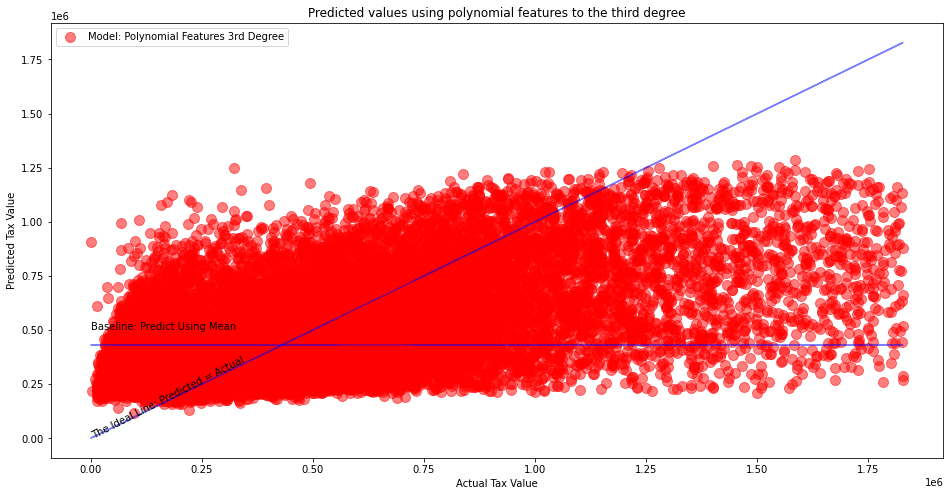

In [44]:
# y_validate.head()
plt.figure(figsize=(16,8))
plt.plot(m4_eval.actual, m4_eval.yhat_baseline, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (0, 500000))
plt.plot(m4_eval.actual, m4_eval.actual, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 4), rotation=27)

plt.scatter(m4_eval.actual, m4_eval.yhat, 
            alpha=.5, color="red", s=100, label="Model: Polynomial Features 3rd Degree")
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.title("Predicted values using polynomial features to the third degree")
# plt.annotate("The polynomial model appears to overreact to noise", (2.0, -10))
# plt.annotate("The OLS model (LinearRegression)\n appears to be most consistent", (15.5, 3))
plt.show()

In [24]:
def get_mvp_model_with_results(train, validate, test):
    
    #Scale data using min-max
    columns_to_scale = ['bedrooms', 'bathrooms','square_feet']
    # make the object, put it into the variable scaler
    scaler = MinMaxScaler()
    # fit the object to my data:
    train[columns_to_scale] = scaler.fit_transform(train[columns_to_scale])
    validate[columns_to_scale] = scaler.transform(validate[columns_to_scale])
    test[columns_to_scale] = scaler.transform(test[columns_to_scale])
    
    #Prep data for modeling iteration 1
    X_train, X_validate, X_test, y_train, y_validate, y_test = mvp_model_prep(train, validate, test)
    #Make a copy of y_train to evaluate results, renaming tax_value
    m1_eval = y_train.copy()
    m1_eval = m1_eval.rename(columns={'tax_value': 'actual'})
    #Establish baseline as mean
    m1_eval['baseline_yhat'] = m1_eval['actual'].mean()
    #Calculate baseline residuals
    m1_eval['residuals'] = m1_eval.baseline_yhat - m1_eval.actual
    #Set model as LR, fit and transform
    lm = LinearRegression(normalize=True)
    lm.fit(X_train, y_train.tax_value)
    #Make Predictions
    m1_eval['ols_yhat'] = lm.predict(X_train)
    #Calculate RMSE
    ols_RMSE = sqrt(mean_squared_error(m1_eval.actual, m1_eval.ols_yhat))
    #Calculate baseline RMSE
    baseline_RMSE = sqrt(mean_squared_error(m1_eval.actual, m1_eval.baseline_yhat))
    # sklearn.metrics.explained_variance_score
    evs = explained_variance_score(m1_eval.actual, m1_eval.ols_yhat)
    
    return print(f'Explained Variance={round(evs,3)}, MVP model RMSE is:{round(ols_RMSE,3)}')

In [9]:
m.get_mvp_model_with_results(train,validate,test)

Explained Variance=0.324, MVP model RMSE is:272435.766


In [9]:
#prep for modeling
X_train, X_validate, X_test, y_train, y_validate, y_test = m.model4_prep(train,validate,test)

In [10]:
X_train.head(2)

,bedrooms,bathrooms,square_feet,home_age,LA
0,0.778779,0.680180,0.648649,0.377878,0
1,0.404404,0.424424,0.520521,0.467467,1


In [18]:
def evaluate_models(X_train, y_train, X_validate, y_validate):
    ''' 
    This function takes in the X and y objects and runs the following models:
    - Baseline model using y_train mean
    - LarsLasso model with alpha=1
    - Polynomial Features 3rd degree with LR
    Then, Returns a DataFrame with the results
    '''
    # Baseline Model
    # run the model
    pred_mean = y_train.tax_value.mean()
    y_train['pred_mean'] = pred_mean
    y_validate['pred_mean'] = pred_mean
    rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_mean, squared=False)
    rmse_val = mean_squared_error(y_validate.tax_value, y_validate.pred_mean, squared=False)

    # save the results
    metrics = pd.DataFrame(data=[{
        'model': 'baseline_mean',
        'rmse_train': rmse_train,
        'r2_train': explained_variance_score(y_train.tax_value, y_train.pred_mean),
        'rmse_val': rmse_val,
        'r2_val': explained_variance_score(y_validate.tax_value, y_validate.pred_mean)}])

    # LassoLars Model
    lars = LassoLars(alpha=1)
    lars.fit(X_train, y_train.tax_value)
    y_train['pred_lars'] = lars.predict(X_train)
    rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_lars, squared=False)
    y_validate['pred_lars'] = lars.predict(X_validate)
    rmse_val = mean_squared_error(y_validate.tax_value, y_validate.pred_lars, squared=False)

    # save the results
    metrics = metrics.append({
        'model': 'LarsLasso, alpha 1',
        'rmse_train': rmse_train,
        'r2_train': explained_variance_score(y_train.tax_value, y_train.pred_lars),
        'rmse_val': rmse_val,
        'r2_val': explained_variance_score(y_validate.tax_value, y_validate.pred_lars)}, ignore_index=True)

    # Polynomial Model, 3rd Degree
    # set up the model
    pf = PolynomialFeatures(degree=3)
    X_train_d2 = pf.fit_transform(X_train)
    X_val_d2 = pf.transform(X_validate)
    
    # run the model
    lm2 = LinearRegression()
    lm2.fit(X_train_d2, y_train.tax_value)
    y_train['pred_lm2'] = lm2.predict(X_train_d2)
    rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_lm2, squared=False)
    y_validate['pred_lm2'] = lm2.predict(X_val_d2)
    rmse_val = mean_squared_error(y_validate.tax_value, y_validate.pred_lm2, squared=False)

    # save the results
    metrics = metrics.append({
        'model': 'Polynomial Features 3rd Degree',
        'rmse_train': rmse_train,
        'r2_train': explained_variance_score(y_train.tax_value, y_train.pred_lm2),
        'rmse_val': rmse_val,
        'r2_val': explained_variance_score(y_validate.tax_value, y_validate.pred_lm2)}, ignore_index=True)

    return metrics

In [20]:
evaluate_models(X_train, y_train, X_validate, y_validate)

,model,rmse_train,r2_train,rmse_val,r2_val
0,baseline_mean,331305.893220,0.000000,334300.072942,0.000000
1,"LarsLasso, alpha 1",283242.026519,0.269102,285178.706960,0.272230
2,Polynomial Features 3rd Degree,264647.536769,0.361954,266112.338620,0.366302


In [11]:
m.evaluate_models(X_train, y_train, X_validate, y_validate)

,model,rmse_train,r2_train,rmse_val,r2_val
0,baseline_mean,331305.893220,0.000000,334300.072942,0.000000
1,"LarsLasso, alpha 1",283242.026519,0.269102,285178.706960,0.272230
2,Polynomial Features 3rd Degree,264546.780255,0.362405,266059.128162,0.366561


In [10]:
#prep for modeling
X_train, X_validate, X_test, y_train, y_validate, y_test = m.model4_prep(train,validate,test)

In [11]:
X_train.head(2)

,bedrooms,bathrooms,square_feet,home_age,LA
0,0.778779,0.680180,0.648649,0.377878,0
1,0.404404,0.424424,0.520521,0.467467,1


In [17]:
def evaluate_model_test(X_train, X_validate, X_test, y_train, y_validate, y_test):
    ''' 
    This function takes in the X and y objects and then runs Polynomial Features 3rd
    Degree Regression Model. It then returns the results in a dataframe, including model
    performance on testing data
    '''
    # set up the model
    pf = PolynomialFeatures(degree=3)
    X_train_d3 = pf.fit_transform(X_train)
    X_val_d3 = pf.transform(X_validate)
    X_test_d3 = pf.transform(X_test)

    # run the model
    lm2 = LinearRegression()
    lm2.fit(X_train_d3, y_train.tax_value)
    y_train['pred_lm2'] = lm2.predict(X_train_d3)
    rmse_train = mean_squared_error(y_train.tax_value, y_train.pred_lm2, squared=False)
    y_validate['pred_lm2'] = lm2.predict(X_val_d3)
    rmse_val = mean_squared_error(y_validate.tax_value, y_validate.pred_lm2, squared=False)
    y_test['pred_lm2'] = lm2.predict(X_test_d3)
    rmse_test = mean_squared_error(y_test.tax_value, y_test.pred_lm2, squared=False)

    # save the results
    results = pd.DataFrame({'train': 
                               {'rmse': rmse_train, 
                                'r2': explained_variance_score(y_train.tax_value, y_train.pred_lm2)},
                           'validate': 
                               {'rmse': rmse_val, 
                                'r2': explained_variance_score(y_validate.tax_value, y_validate.pred_lm2)},
                           'test': 
                               {'rmse': rmse_test, 
                                'r2': explained_variance_score(y_test.tax_value, y_test.pred_lm2)}
                          })
    
    return results

In [12]:
m.evaluate_model_test(X_train, X_validate, X_test, y_train, y_validate, y_test)

,train,validate,test
rmse,264546.780255,266059.128162,266196.116659
r2,0.362405,0.366561,0.361712


In [ ]:
#Making visualization for model performance

In [9]:
#prep for modeling
X_train, X_validate, X_test, y_train, y_validate, y_test = m.model4_prep(train,validate,test)

In [10]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree3 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)

In [11]:
# create the model object
pf3 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
pf3.fit(X_train_degree3, y_train.tax_value)

# predict train
y_train['tax_value_pred_pf3'] = pf3.predict(X_train_degree3)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.tax_value_pred_pf3)**(1/2)

# predict validate
y_validate['tax_value_pred_pf3'] = pf3.predict(X_validate_degree3)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.tax_value_pred_pf3)**(1/2)

print("RMSE for Polynomial Model, degrees=3\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Polynomial Model, degrees=3
Training/In-Sample:  264451.5095265614 
Validation/Out-of-Sample:  266047.5800240631


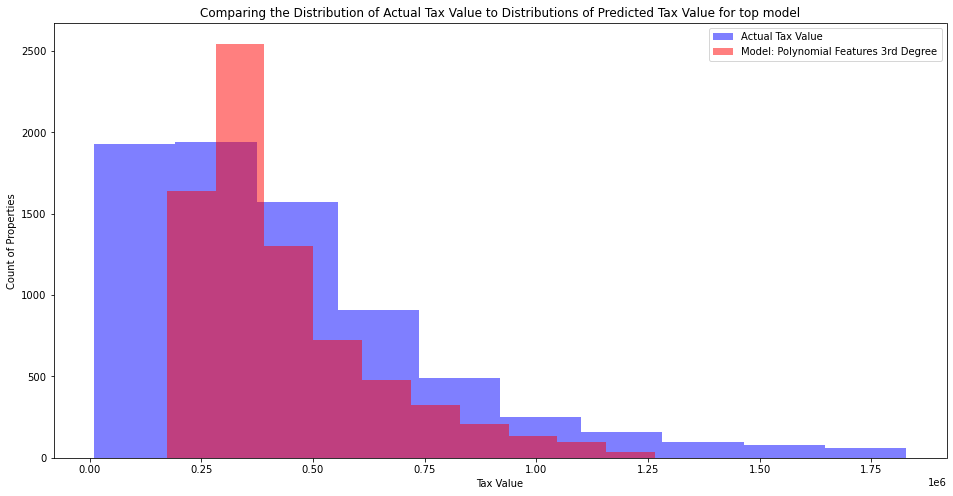

In [12]:
# plot to visualize actual vs predicted. 
plt.figure(figsize=(16,8))
plt.hist(y_validate.tax_value, color='blue', alpha=.5, label="Actual Tax Value")
plt.hist(y_validate.tax_value_pred_pf3, color='red', alpha=.5, label="Model: Polynomial Features 3rd Degree")
plt.xlabel("Tax Value")
plt.ylabel("Count of Properties")
plt.title("Comparing the Distribution of Actual Tax Value to Distribution of Predicted Tax Value for top model")
plt.legend()
plt.show()

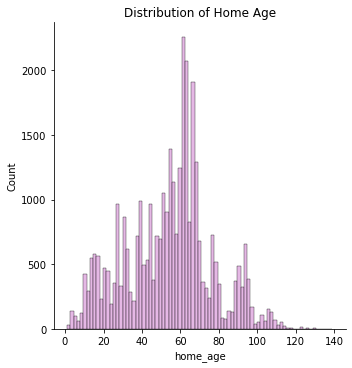

In [15]:
#home age vs tax value distplot
sns.displot(train['home_age'], color='plum')
plt.title('Distribution of Home Age')
plt.show()

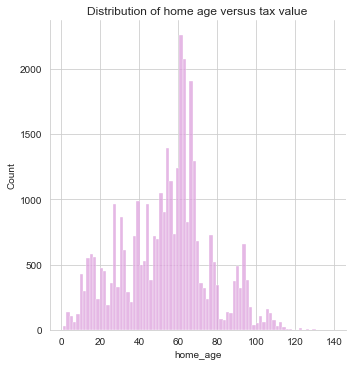

In [30]:
sns.displot(train['home_age'], color='plum')
plt.title('Distribution of home age versus tax value')
plt.show()

In [10]:
def home_age_viz(train):
    '''This function takes in train, takes a sample (0.05) of training data
    to facilitate a scatter plot of home age'''
    sample = train.sample(frac=0.05)
    #Set theme
    sns.set_theme()
    #Set Plot Size
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 7)
    #Create seaborn regplot
    ax = sns.regplot(sample['home_age'],sample['tax_value'], scatter_kws={"color": "steelblue"},
                 line_kws={"color": "limegreen"}, ax=ax)
    #Specify Axis labels
    ax.set(xlabel='Home Age',
       ylabel='Tax Value',
       title='Home Value Decreases as Home Age Increases')
    plt.show()

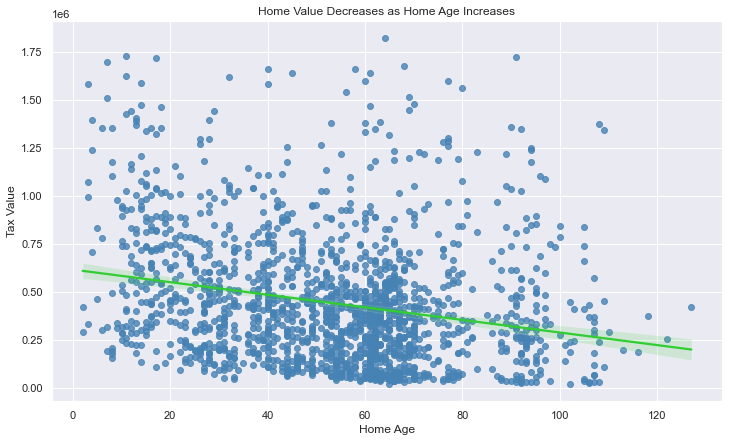

In [9]:
e.home_age_viz(train)

In [32]:
sample = train.sample(frac=0.05)

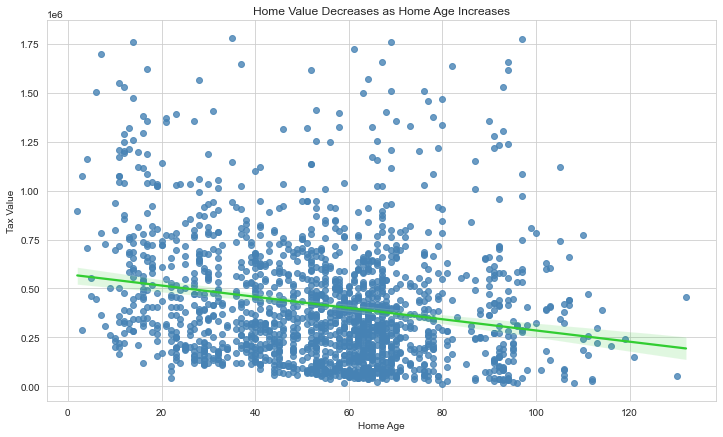

In [46]:
#Set Plot Size
fig, ax = plt.subplots()
fig.set_size_inches(12, 7)
#Create seaborn regplot
ax = sns.regplot(sample['home_age'],sample['tax_value'], scatter_kws={"color": "steelblue"},
                 line_kws={"color": "limegreen"}, ax=ax)
#Specify Axis labels
ax.set(xlabel='Home Age',
       ylabel='Tax Value',
       title='Home Value Decreases as Home Age Increases')
plt.show()

In [12]:
sample = train.sample(frac=0.05)

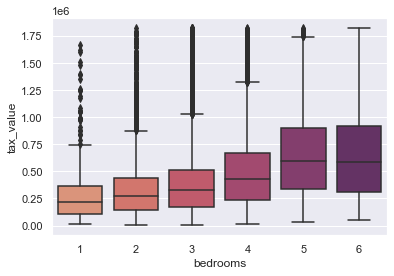

In [21]:
#Set Style and palette
sns.set_style()
sns.set_palette('flare')
sns.boxplot(data=train, x="bedrooms", y="tax_value")
plt.show()

In [29]:
#Make bathrooms into an integer
train['bathrooms_int'] = train.bathrooms.astype(int)

In [45]:
def bed_bath_viz(train):
    '''This function takes in training data and plots boxplots for bedrooms and bathrooms
    in comparison to Tax Value using Seaborn Boxplots and Styling'''
    #Set Style and Palette
    sns.set_style()
    # Define Axes and plot 2 boxplots
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,6), sharey=True)
    sns.boxplot(data=train, x='bedrooms', y='tax_value', palette = 'flare', ax=ax1)
    sns.boxplot(data=train, x='bathrooms', y='tax_value', palette = 'flare', ax=ax2)
    #Set Plot Titles
    ax1.set_title ("Bedrooms")
    ax2.set_title("Bathrooms")
    plt.suptitle ("As Bedrooms and Bathrooms increase, so does Tax Value")
    #Set Plot Labels Subplot 1
    ax1.set_xlabel( "Bedrooms")
    ax1.set_ylabel( "Tax Value")
    # Set plot labels subplot 2
    ax2.set_xlabel( "Bathrooms")
    ax2.set_ylabel( "Tax Value")
    #Make the plot
    plt.show()

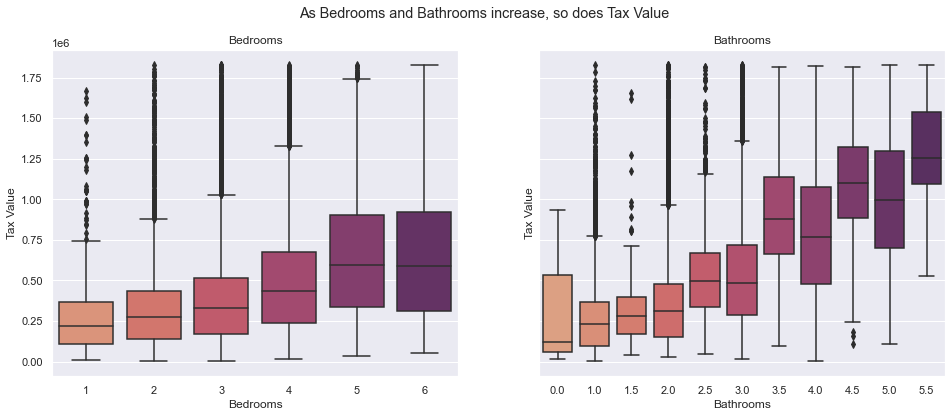

In [46]:
bed_bath_viz(train)

In [57]:
def county_viz(train):
    '''This function takes in training data and outputs a visualization representing the difference in home value
    by county, with lines indicating mean tax value for properties'''
    # Binning Home Value
    train['brackets'] = pd.cut(train.tax_value, 10, labels=[1,2,3,4,5,6,7,8,9,10])
    #Set theme
    sns.set_theme()
    #Set Palette
    palette = {
    'Ventura': 'black',
    'Orange': '#89bedc',
    'Los Angeles': '#2b7bba'}
    # Set Size
    plt.figure(figsize=(12,8))
    # plot it
    sns.histplot(data=train, x='tax_value', alpha=.8, hue='county', hue_order=['Ventura', 'Orange', 'Los Angeles'], palette=palette)
    # add lines marking the mean value at each location
    plt.axvline(x=train[train.county == 'Los Angeles'].tax_value.mean(), color='#2b7bba', linestyle='--')
    plt.axvline(x=train[train.county == 'Orange'].tax_value.mean(), color='#89bedc', linestyle='--')
    plt.axvline(x=train[train.county == 'Ventura'].tax_value.mean(), color='black', linestyle='--')
    
    # axis tick labeling using
    plt.xticks(ticks = [0,200000,400000,600000,800000,1000000, 1200000], labels=['0', '200,000', '400,000', '600,000', '800,000', '1,000,000', '1,200,000'])
    
    # Make a title, label the axes
    plt.title('Tax Value by County, With Dashed Lines Indicating County Mean Values')
    plt.xlabel('Tax Value')
    plt.ylabel('Count of Homes')
    plt.show()
    
    print()

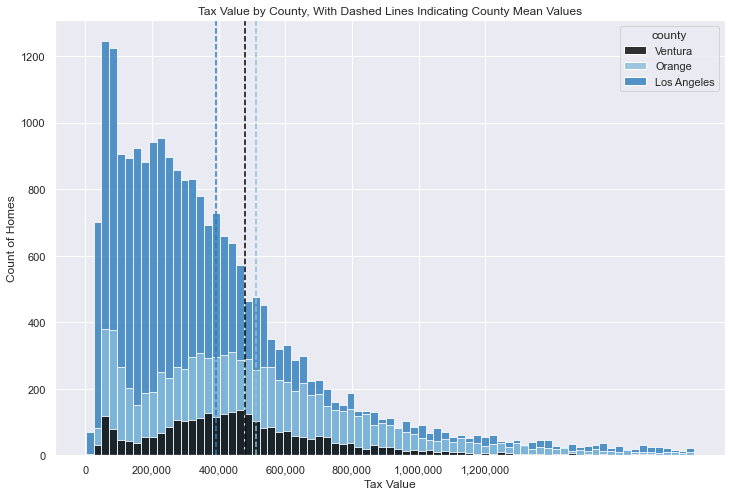

In [9]:
e.county_viz(train)